# Setup

## Imports

In [1]:
import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

┌ Info: new driver key :netcdf, updating backendlist.
└ @ NetCDFExt /home/gr400/.julia/packages/YAXArrayBase/Xj43k/ext/NetCDFExt.jl:81


## Logger Setups

In [2]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Loading Model and json

In [3]:
Mode3 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3/Mode3.json");
proj_dict = SC.Utils.Get_Projection_Ops(Mode3.dressed_states);

device_config = JSON3.read("device_config_files/config_multimode.json", Dict{Any, Any});

In [4]:
GLOBAL_SAVE_CALIBRATE = true;

# Calibrating Pulses

## Qubit Pulses

### Guasisan g -> e

In [5]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ge"]["sigma"]))

Target σ: 0.023251488095238096


#### Getting Stark Shift

[2024-11-06 20:18:01] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


[2024-11-06 20:18:13] Info: Done With Floquet Sweep
[2024-11-06 20:18:14] Info: Fit Stuff: 3-element Vector{Float64}:	 0.00036034889159504137	 0.008953334260644905	 2.006707841225457
Stark shift res: [0.00036034889159504137, 55.658443075794686]


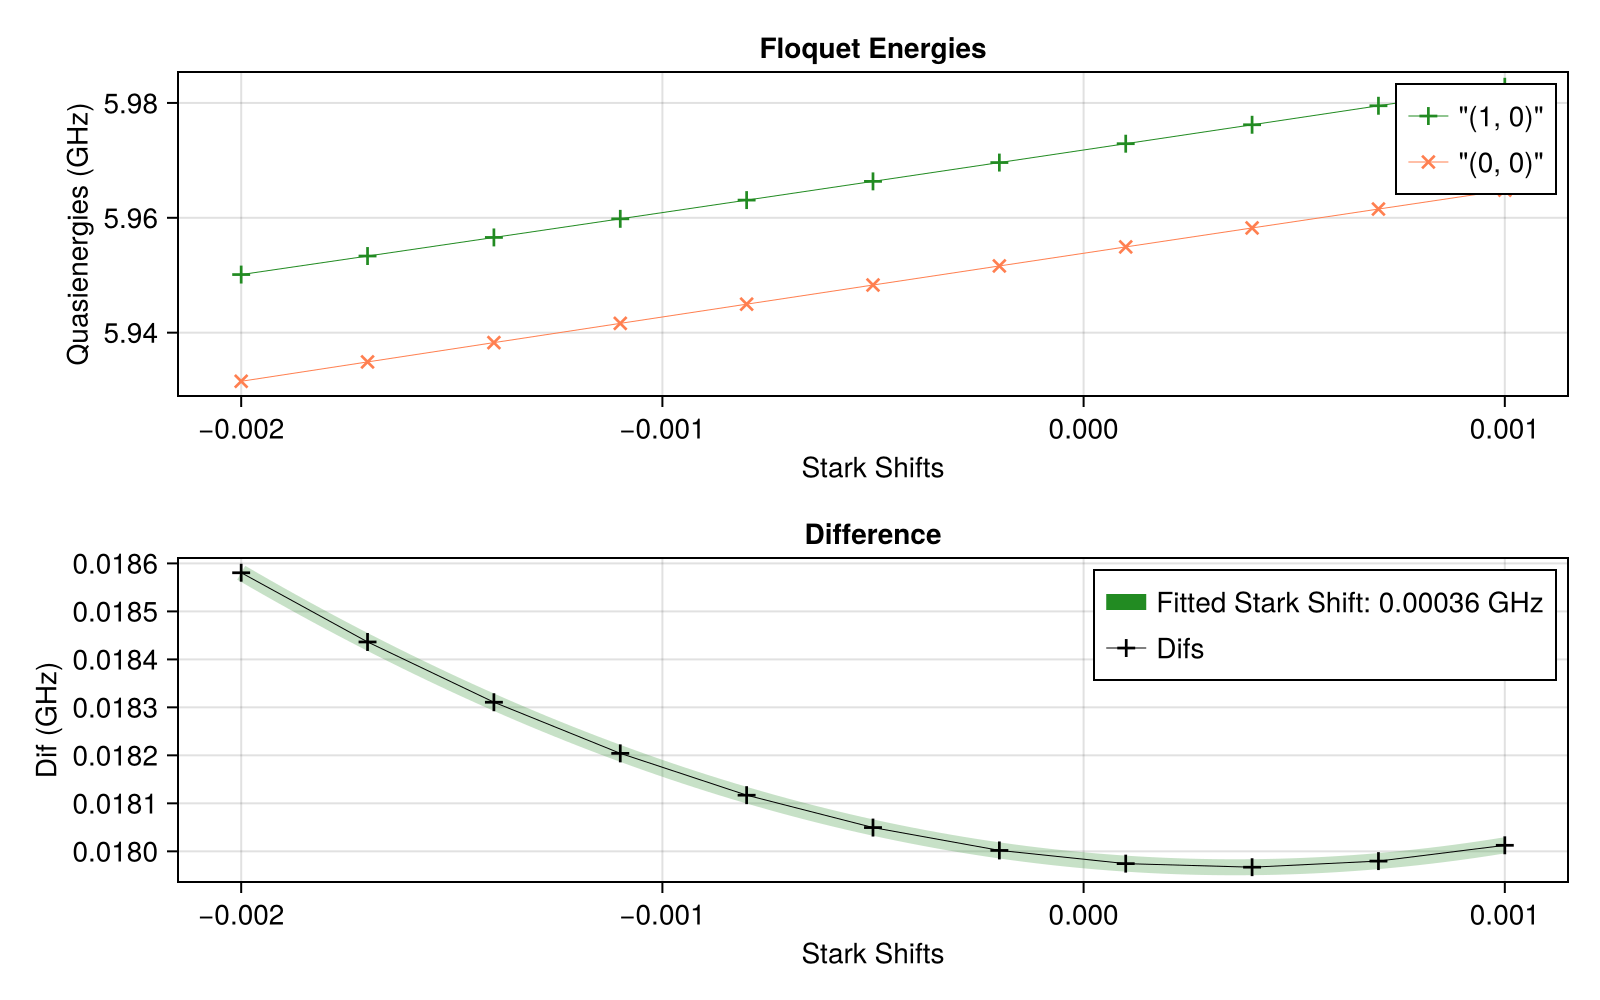

In [6]:
ge_ε = 0.00538
drive_op = Mode3.n̂ₜ
state1 = (0,0)
state2 = (1,0)

stark_shift_list = collect(LinRange(-0.002, 0.001, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode3, state1, state2, ge_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))
ge_stark_shift = stark_shift_res[1];

#### $|1,0\rangle+|0,1\rangle \to |0,0\rangle+|1,1\rangle$

In [7]:

ψ1 = Mode3.dressed_states[(1,0)]+Mode3.dressed_states[(0,1)]
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode3.dressed_states[(0,0)]+Mode3.dressed_states[(1,1)]
ψ2 = ψ2/qt.norm(ψ2)

freq_d_e0 = Mode3.dressed_energies[(1,0)]-Mode3.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode3.dressed_energies[(1,1)]-Mode3.dressed_energies[(0,1)]+ge_stark_shift

freq_d = (freq_d_e0+freq_d_g1)/2

check_op = proj_dict[(0,0)]+proj_dict[(1,1)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

#qubit_ε = qubit_ε

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_half = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-06 20:18:26] Info: On Level 1
[2024-11-06 20:18:26] Info: On Step 1: t = 90.0
[2024-11-06 20:18:26] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-06 20:18:30] Info: Time Evolution Complete
[2024-11-06 20:18:30] Info: Done with Level_1_step_1
[2024-11-06 20:18:30] Info: Accurace: 0.9968628763570699
[2024-11-06 20:18:30] Info: ------------------------------------------------------------------------------
[2024-11-06 20:18:30] Info: On Step 2: t = 92.5
[2024-11-06 20:18:30] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:18:31] Info: Time Evolution Complete
[2024-11-06 20:18:31] Info: Done with Level_1_step_2
[2024-11-06 20:18:31] Info: Accurace: 0.9993159846161722
[2024-11-06 20:18:31] Info: ------------------------------------------------------------------------------
[2024-11-06 20:18:31] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999383
  "freq_d"        => 4.60393

In [8]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["q_ge_1/2"] = deepcopy(qubit_ge_half)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999383
  "freq_d"        => 4.60393

In [9]:
ψ = Mode3.dressed_states[(1,0)]+Mode3.dressed_states[(0,1)]
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_half_res = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["q_ge_1/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-06T20:19:17.091
It is being saved at: Data/
[2024-11-06 20:19:17] Info: Running operator q_ge_1/2
[2024-11-06 20:19:17] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-06 20:19:19] Info: Time Evolution Complete
[2024-11-06 20:19:19] Info: Saving Steps
[2024-11-06 20:19:24] Info: Done with Step_1
[2024-11-06 20:19:24] Info: Done With Running Sequence
[2024-11-06 20:19:24] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [10]:
EVs = SC.Utils.Get_EVs(q_ge_half_res["states"], proj_dict);

[2024-11-06 20:19:27] Info: Making Plot


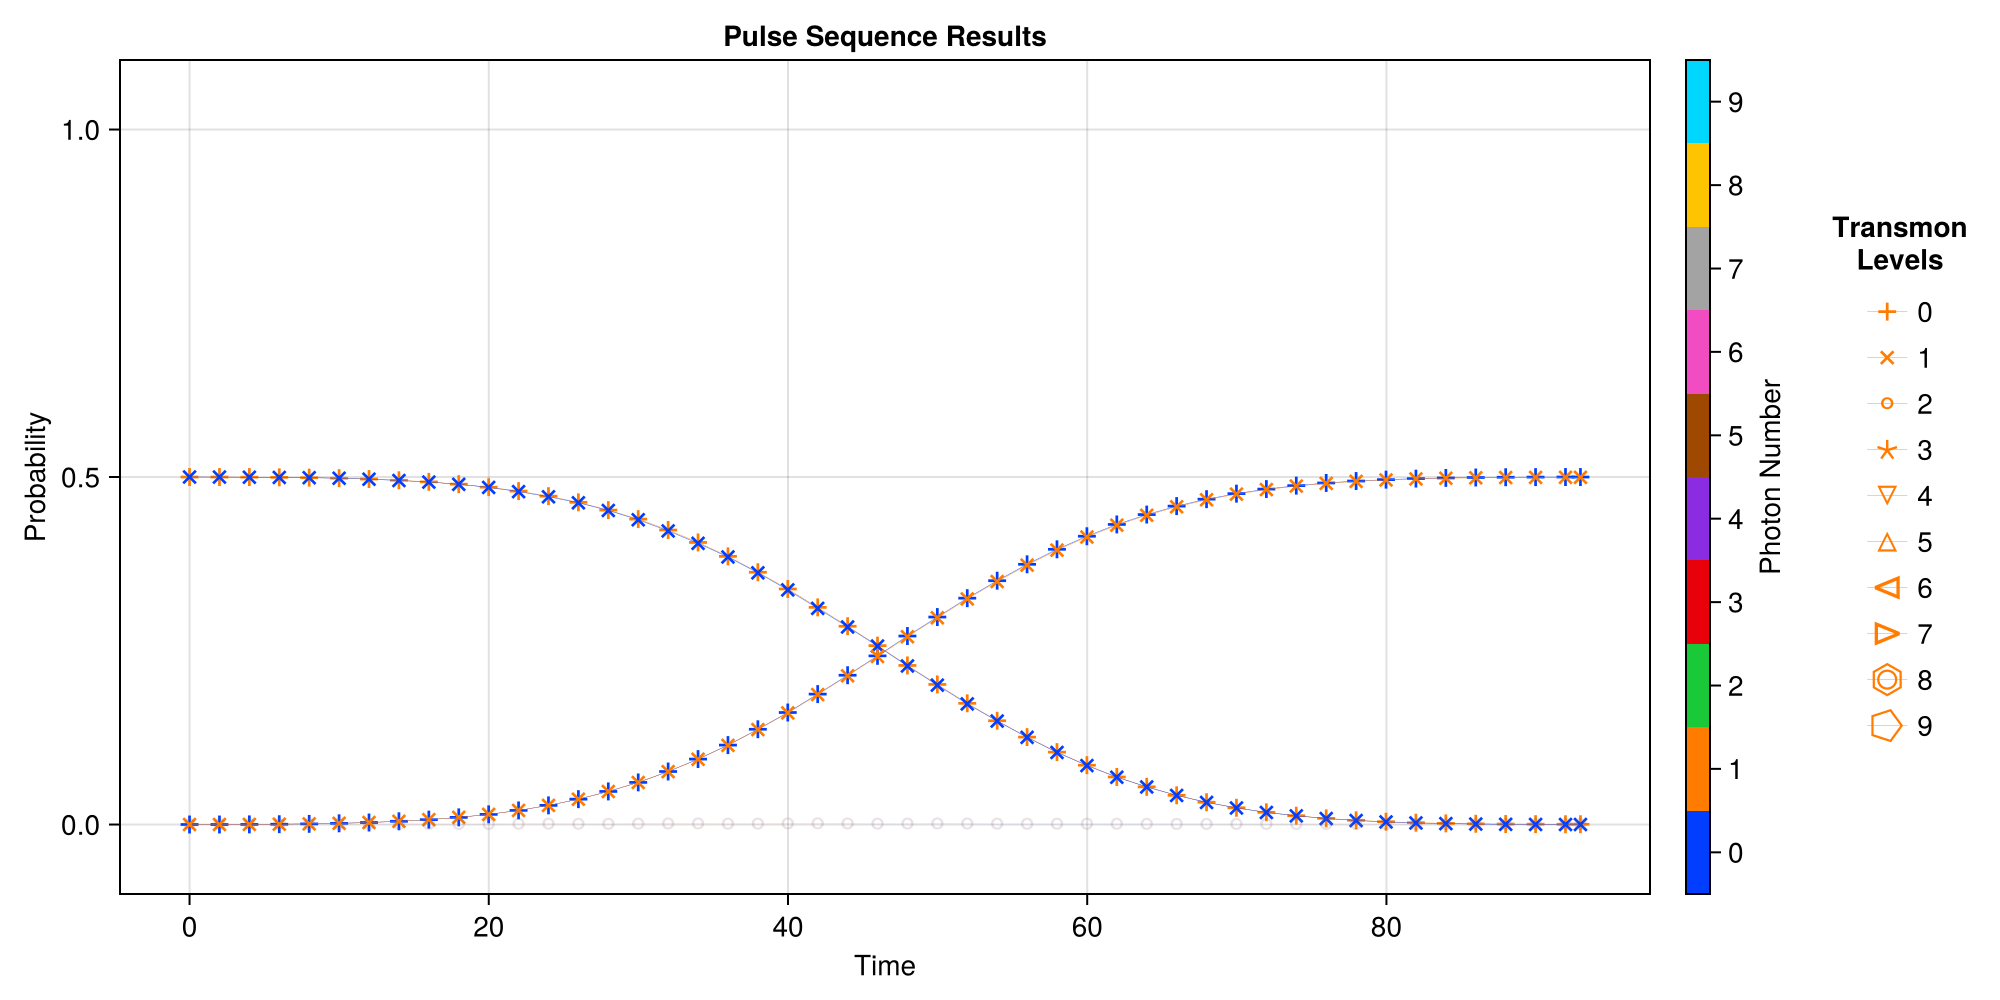

CairoMakie.Screen{IMAGE}


In [11]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, q_ge_half_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1)])

In [12]:
println(EVs[(0,0)][end])
println(EVs[(1,1)][end])

0.4999683845602616 - 9.472898887950948e-18im
0.4995409555677781 + 2.942455226604916e-17im


In [13]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997285132005 + 2.013491610924826e-17im

#### $|0,0\rangle \to |1,0\rangle$

In [14]:
state1 = (0,0)
state2 = (1,0)
ψ1 = Mode3.dressed_states[state1]
ψ2 = Mode3.dressed_states[state2]

freq_d = Mode3.dressed_energies[state2]-Mode3.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge0_opt_res = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-06 20:19:33] Info: On Level 1
[2024-11-06 20:19:33] Info: On Step 1: t = 90.0
[2024-11-06 20:19:33] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:19:34] Info: Time Evolution Complete
[2024-11-06 20:19:34] Info: Done with Level_1_step_1
[2024-11-06 20:19:34] Info: Accurace: 0.996858296483769
[2024-11-06 20:19:34] Info: ------------------------------------------------------------------------------
[2024-11-06 20:19:34] Info: On Step 2: t = 92.5
[2024-11-06 20:19:34] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:19:35] Info: Time Evolution Complete
[2024-11-06 20:19:35] Info: Done with Level_1_step_2
[2024-11-06 20:19:35] Info: Accurace: 0.9993160542779679
[2024-11-06 20:19:35] Info: ------------------------------------------------------------------------------
[2024-11-06 20:19:35] Info: On S

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999378
  "freq_d"        => 4.60403

In [15]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["q_ge_0"] = deepcopy(qubit_ge0_opt_res)
end


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999378
  "freq_d"        => 4.60403

In [16]:
ψ = Mode3.dressed_states[(0,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge0_res = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["q_ge_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-06T20:20:19.492
It is being saved at: Data/
[2024-11-06 20:20:19] Info: Running operator q_ge_0
[2024-11-06 20:20:19] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-06 20:20:23] Info: Time Evolution Complete
[2024-11-06 20:20:23] Info: Saving Steps
[2024-11-06 20:20:24] Info: Done with Step_1
[2024-11-06 20:20:24] Info: Done With Running Sequence
[2024-11-06 20:20:24] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [17]:
EVs_ge0 = SC.Utils.Get_EVs(q_ge0_res["states"], proj_dict);

[2024-11-06 20:20:24] Info: Making Plot


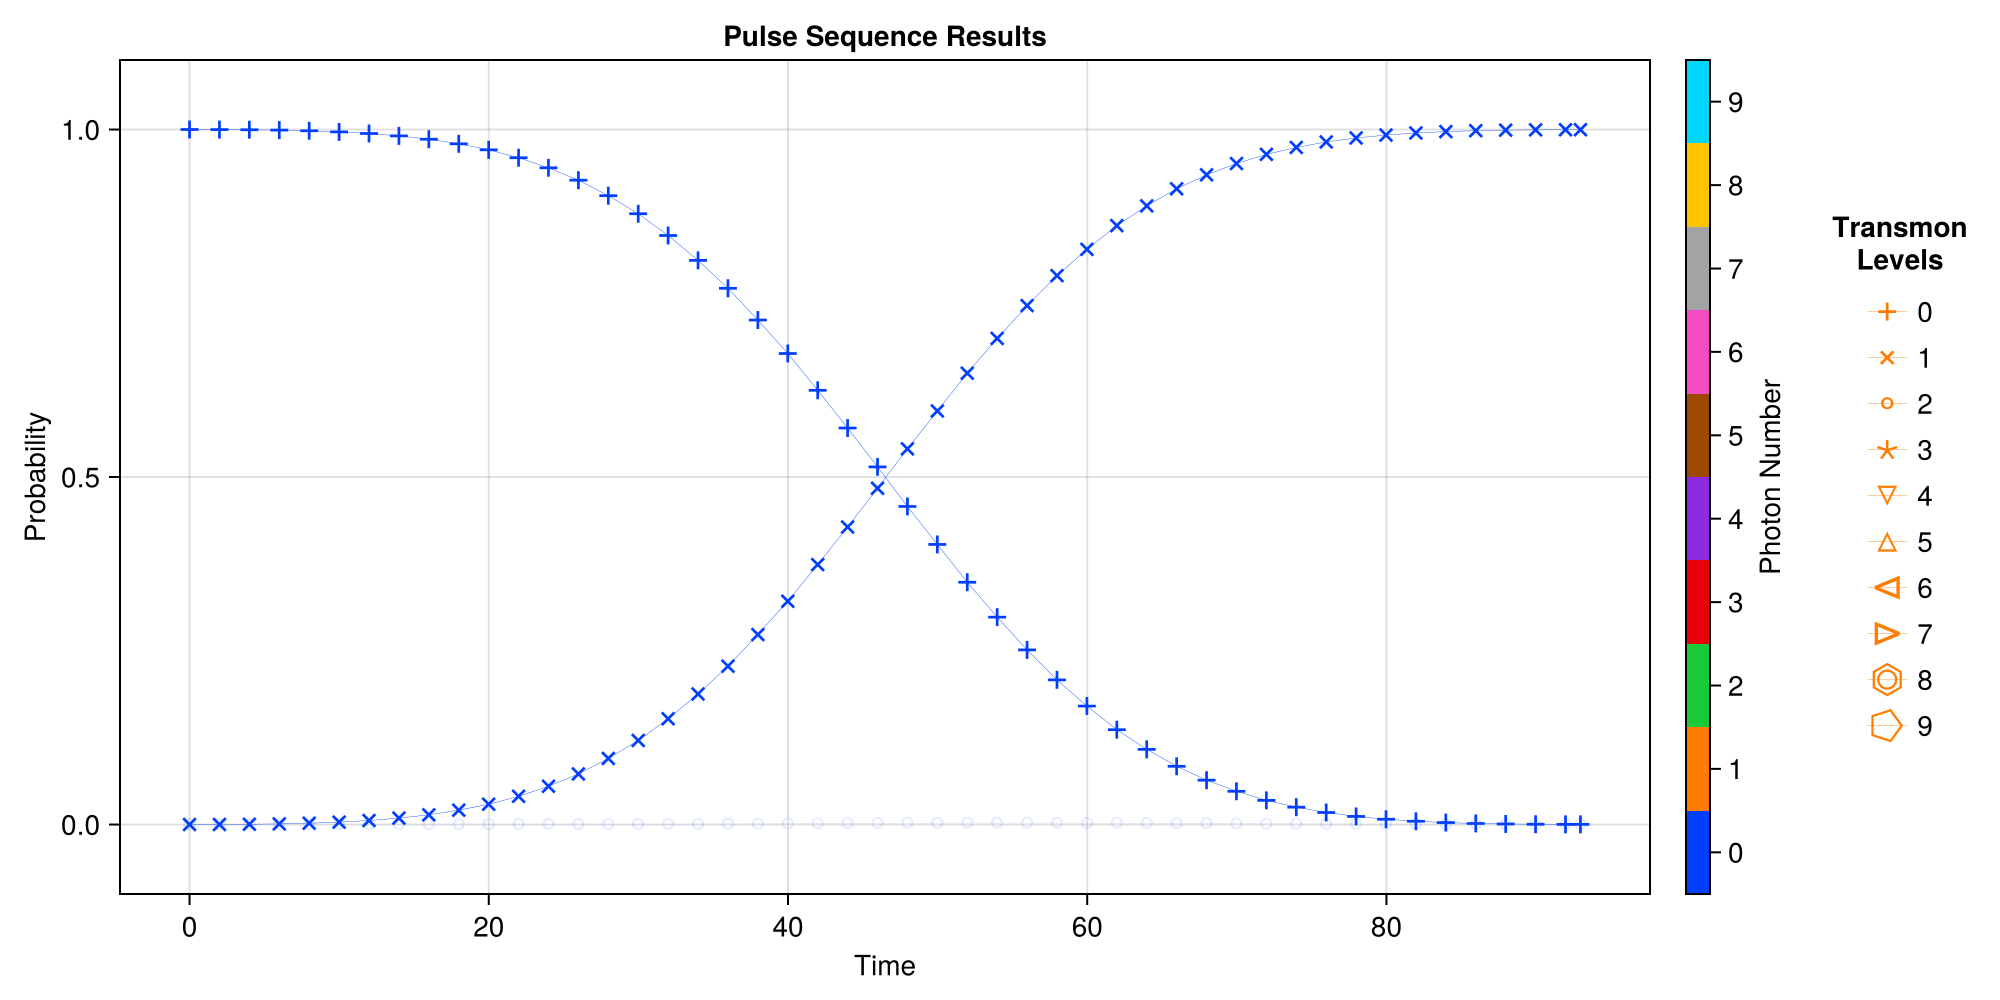

CairoMakie.Screen{IMAGE}


In [18]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, q_ge0_res["times"], EVs_ge0, plot_every = 10, emph_states = [(0,0),(1,0)])

In [19]:
println(EVs_ge0[(0,0)][end])
println(EVs_ge0[(1,0)][end])
println(EVs_ge0[(2,0)][end])

0.00022541692165968337 - 9.368780389466863e-21im
0.9997120740736584 - 2.99985430376942e-17im
6.210533599544379e-5 - 4.8525155449823644e-21im


In [20]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997285132005 + 2.013491610924826e-17im

#### $|0,1\rangle \to |1,1\rangle$

In [21]:
state1 = (0,1)
state2 = (1,1)
ψ1 = Mode3.dressed_states[state1]
ψ2 = Mode3.dressed_states[state2]

freq_d = Mode3.dressed_energies[state2]-Mode3.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge1_opt_res = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-06 20:20:24] Info: On Level 1
[2024-11-06 20:20:24] Info: On Step 1: t = 90.0
[2024-11-06 20:20:24] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:20:26] Info: Time Evolution Complete
[2024-11-06 20:20:26] Info: Done with Level_1_step_1
[2024-11-06 20:20:26] Info: Accurace: 0.9971526601750033
[2024-11-06 20:20:26] Info: ------------------------------------------------------------------------------
[2024-11-06 20:20:26] Info: On Step 2: t = 92.5
[2024-11-06 20:20:26] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:20:27] Info: Time Evolution Complete
[2024-11-06 20:20:27] Info: Done with Level_1_step_2
[2024-11-06 20:20:27] Info: Accurace: 0.9996243914369981
[2024-11-06 20:20:27] Info: ------------------------------------------------------------------------------
[2024-11-06 20:20:27] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999692
  "freq_d"        => 4.60382

In [22]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["q_ge_1"] = deepcopy(qubit_ge1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999692
  "freq_d"        => 4.60382

In [23]:
ψ = Mode3.dressed_states[(0,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge1_res = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["q_ge_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-06T20:21:12.064
It is being saved at: Data/
[2024-11-06 20:21:12] Info: Running operator q_ge_1
[2024-11-06 20:21:12] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-06 20:21:14] Info: Time Evolution Complete
[2024-11-06 20:21:14] Info: Saving Steps
[2024-11-06 20:21:15] Info: Done with Step_1
[2024-11-06 20:21:15] Info: Done With Running Sequence
[2024-11-06 20:21:15] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [24]:
EVs = SC.Utils.Get_EVs(q_ge1_res["states"], proj_dict);

[2024-11-06 20:21:15] Info: Making Plot


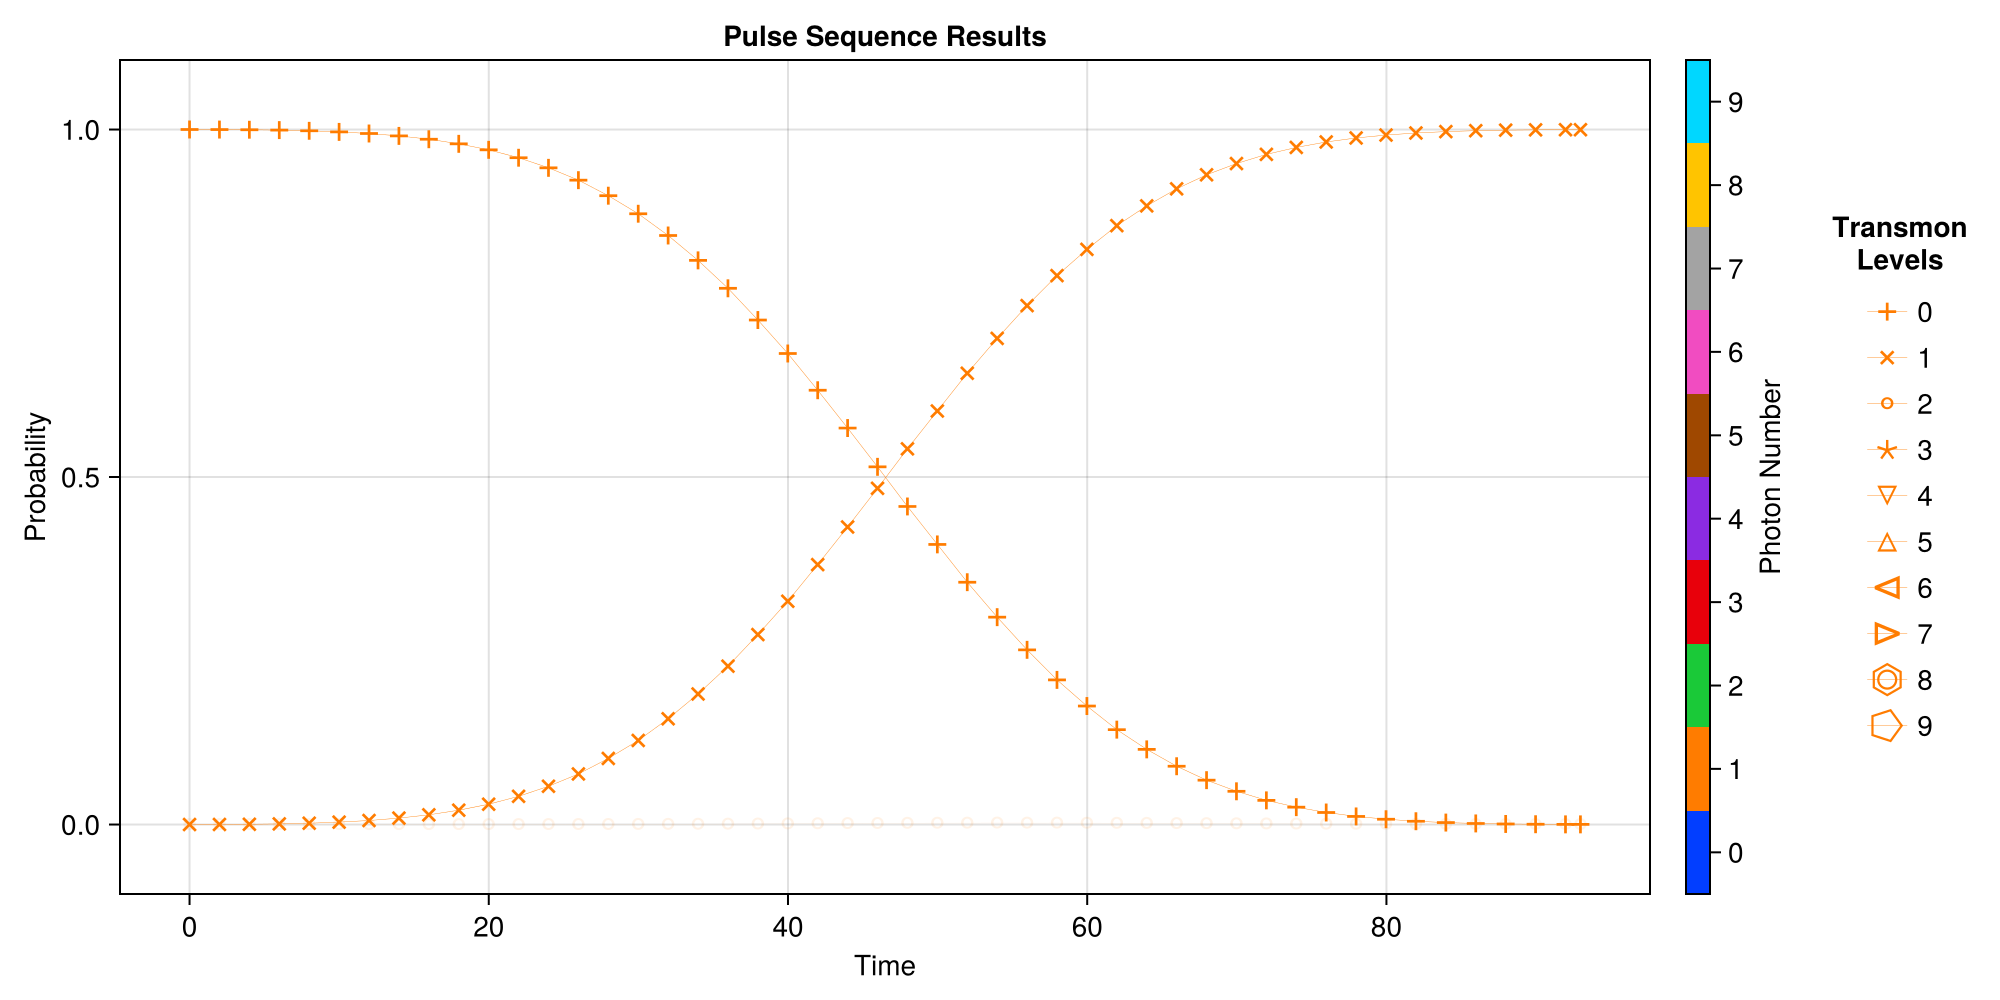

CairoMakie.Screen{IMAGE}


In [25]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, q_ge1_res["times"], EVs, plot_every = 10, emph_states = [(0,1),(1,1)])

In [26]:
EVs[(1,1)][end]

0.9997102383678087 - 6.016099949218113e-17im

In [27]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999975645827426 - 6.014035851836924e-17im

#### $|0,0\rangle+(|1,1\rangle+|0,3\rangle)/\sqrt{2} \to |1,0\rangle+(|0,1\rangle+|1,3\rangle)/\sqrt{2}$

In [28]:

ψ1 = Mode3.dressed_states[(0,0)]+(Mode3.dressed_states[(1,1)]+Mode3.dressed_states[(0,3)])/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode3.dressed_states[(1,0)]+(Mode3.dressed_states[(0,1)]+Mode3.dressed_states[(1,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_g0 = Mode3.dressed_energies[(1,0)]-Mode3.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode3.dressed_energies[(1,1)]-Mode3.dressed_energies[(0,1)]+ge_stark_shift
freq_d_g3 = Mode3.dressed_energies[(1,3)]-Mode3.dressed_energies[(0,3)]+ge_stark_shift

χ = freq_d_g1-freq_d_g0

freq_d = freq_d_g0+4*χ/3

check_op = proj_dict[(1,0)]+proj_dict[(0,1)]+proj_dict[(1,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_four_thirds_opt_res = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-06 20:21:15] Info: On Level 1
[2024-11-06 20:21:15] Info: On Step 1: t = 90.0
[2024-11-06 20:21:15] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:21:17] Info: Time Evolution Complete
[2024-11-06 20:21:17] Info: Done with Level_1_step_1
[2024-11-06 20:21:17] Info: Accurace: 0.9960402323126842
[2024-11-06 20:21:17] Info: ------------------------------------------------------------------------------
[2024-11-06 20:21:17] Info: On Step 2: t = 92.5
[2024-11-06 20:21:17] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:21:18] Info: Time Evolution Complete
[2024-11-06 20:21:18] Info: Done with Level_1_step_2
[2024-11-06 20:21:18] Info: Accurace: 0.9984398507930654
[2024-11-06 20:21:18] Info: ------------------------------------------------------------------------------
[2024-11-06 20:21:18] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.998492
  "freq_d"        => 4.60376

In [29]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["q_ge_4/3"] = deepcopy(qubit_ge_four_thirds_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.998492
  "freq_d"        => 4.60376

In [30]:
ψ = Mode3.dressed_states[(1,1)]+(Mode3.dressed_states[(0,0)]+Mode3.dressed_states[(0,3)])/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_four_thirds_res = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["q_ge_4/3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-06T20:22:02.900
It is being saved at: Data/
[2024-11-06 20:22:02] Info: Running operator q_ge_4/3
[2024-11-06 20:22:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-06 20:22:06] Info: Time Evolution Complete
[2024-11-06 20:22:06] Info: Saving Steps
[2024-11-06 20:22:07] Info: Done with Step_1
[2024-11-06 20:22:07] Info: Done With Running Sequence
[2024-11-06 20:22:07] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [31]:
EVs = SC.Utils.Get_EVs(q_ge_four_thirds_res["states"], proj_dict);

[2024-11-06 20:22:07] Info: Making Plot


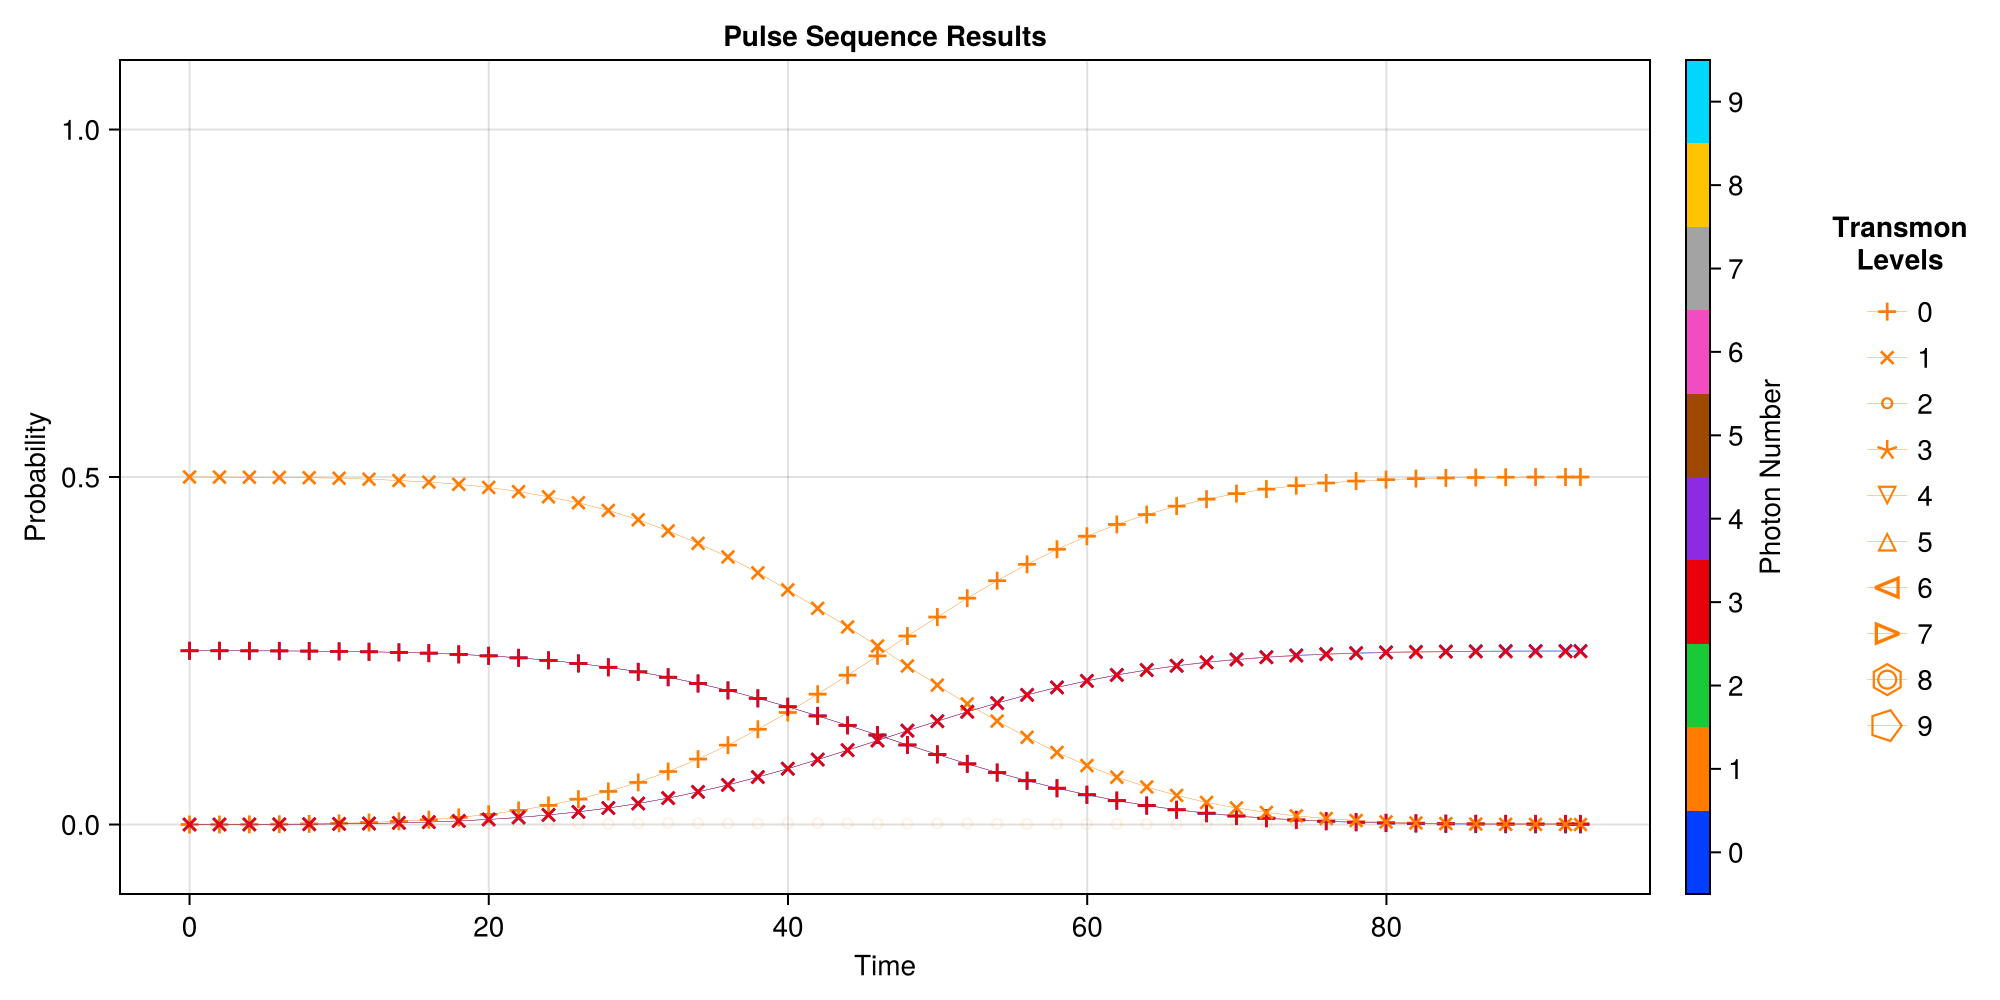

CairoMakie.Screen{IMAGE}


In [32]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, q_ge_four_thirds_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1),(0,3),(1,3)])

In [33]:
println(EVs[(0,1)][end])
println(EVs[(1,0)][end])
println(EVs[(1,3)][end])

0.49995374114719343 + 1.8153562713126034e-19im
0.24985164048164393 + 1.6875255225731827e-17im
0.24901025612337394 + 3.3724407896447266e-19im


In [34]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999998155846894 + 1.7387357400299326e-17im

#### $|0,2\rangle \to |1,2\rangle$

In [35]:
state1 = (0,2)
state2 = (1,2)
ψ1 = Mode3.dressed_states[state1]
ψ2 = Mode3.dressed_states[state2]

freq_d = Mode3.dressed_energies[state2]-Mode3.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge2_opt_res = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-06 20:22:07] Info: On Level 1
[2024-11-06 20:22:07] Info: On Step 1: t = 90.0
[2024-11-06 20:22:07] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:22:09] Info: Time Evolution Complete
[2024-11-06 20:22:09] Info: Done with Level_1_step_1
[2024-11-06 20:22:09] Info: Accurace: 0.997168042605001
[2024-11-06 20:22:09] Info: ------------------------------------------------------------------------------
[2024-11-06 20:22:09] Info: On Step 2: t = 92.5
[2024-11-06 20:22:09] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:22:11] Info: Time Evolution Complete
[2024-11-06 20:22:11] Info: Done with Level_1_step_2
[2024-11-06 20:22:11] Info: Accurace: 0.9996440086245659
[2024-11-06 20:22:11] Info: ------------------------------------------------------------------------------
[2024-11-06 20:22:11] Info: On S

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999712
  "freq_d"        => 4.60362

In [36]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["q_ge_2"] = deepcopy(qubit_ge2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999712
  "freq_d"        => 4.60362

In [37]:
ψ = Mode3.dressed_states[(0, 2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge2_res = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["q_ge_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-06T20:22:57.682
It is being saved at: Data/
[2024-11-06 20:22:57] Info: Running operator q_ge_2
[2024-11-06 20:22:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:22:59] Info: Time Evolution Complete
[2024-11-06 20:22:59] Info: Saving Steps
[2024-11-06 20:22:59] Info: Done with Step_1
[2024-11-06 20:22:59] Info: Done With Running Sequence
[2024-11-06 20:22:59] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [38]:
EVs = SC.Utils.Get_EVs(q_ge2_res["states"], proj_dict);

[2024-11-06 20:23:00] Info: Making Plot


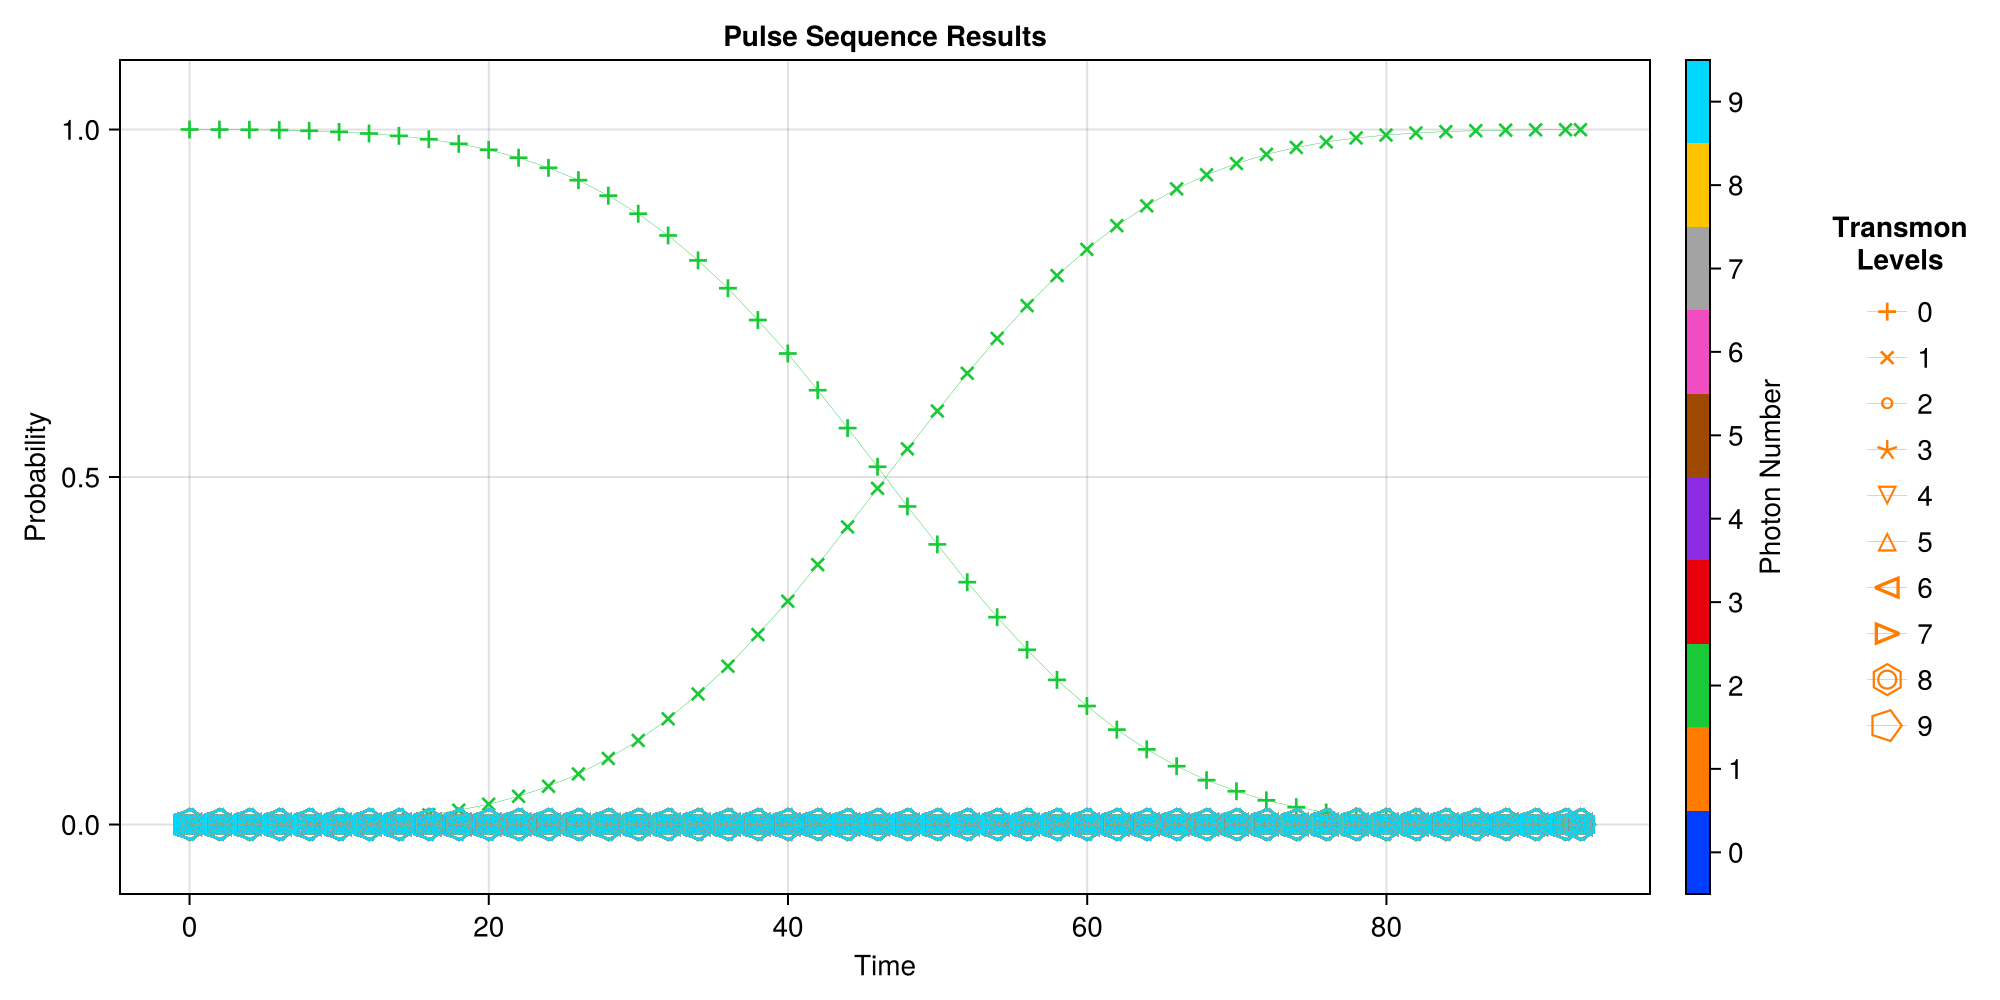

CairoMakie.Screen{IMAGE}


In [39]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, q_ge2_res["times"], EVs, plot_every = 10)

In [40]:
EVs[(1,2)][end]

0.9997126383220035 - 9.978559198368718e-17im

In [41]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999998001960472 - 9.898214079465649e-17im

#### $|0,3\rangle \to |1,3\rangle$

In [42]:
state1 = (0,3)
state2 = (1,3)
ψ1 = Mode3.dressed_states[state1]
ψ2 = Mode3.dressed_states[state2]

freq_d = Mode3.dressed_energies[state2]-Mode3.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge3_opt_res = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-06 20:23:00] Info: On Level 1
[2024-11-06 20:23:00] Info: On Step 1: t = 90.0
[2024-11-06 20:23:00] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:23:02] Info: Time Evolution Complete
[2024-11-06 20:23:02] Info: Done with Level_1_step_1
[2024-11-06 20:23:02] Info: Accurace: 0.9971632571458495
[2024-11-06 20:23:02] Info: ------------------------------------------------------------------------------
[2024-11-06 20:23:02] Info: On Step 2: t = 92.5
[2024-11-06 20:23:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-06 20:23:04] Info: Time Evolution Complete
[2024-11-06 20:23:04] Info: Done with Level_1_step_2
[2024-11-06 20:23:04] Info: Accurace: 0.9996435164127936
[2024-11-06 20:23:04] Info: ------------------------------------------------------------------------------
[2024-11-06 20:23:04] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60341

In [43]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["q_ge_3"] = deepcopy(qubit_ge3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60341

In [44]:
ψ = Mode3.dressed_states[(0, 3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge3_res = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["q_ge_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-06T20:23:50.623
It is being saved at: Data/
[2024-11-06 20:23:50] Info: Running operator q_ge_3
[2024-11-06 20:23:50] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:23:52] Info: Time Evolution Complete
[2024-11-06 20:23:52] Info: Saving Steps
[2024-11-06 20:23:52] Info: Done with Step_1
[2024-11-06 20:23:52] Info: Done With Running Sequence
[2024-11-06 20:23:52] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [45]:
EVs = SC.Utils.Get_EVs(q_ge3_res["states"], proj_dict);

[2024-11-06 20:23:53] Info: Making Plot


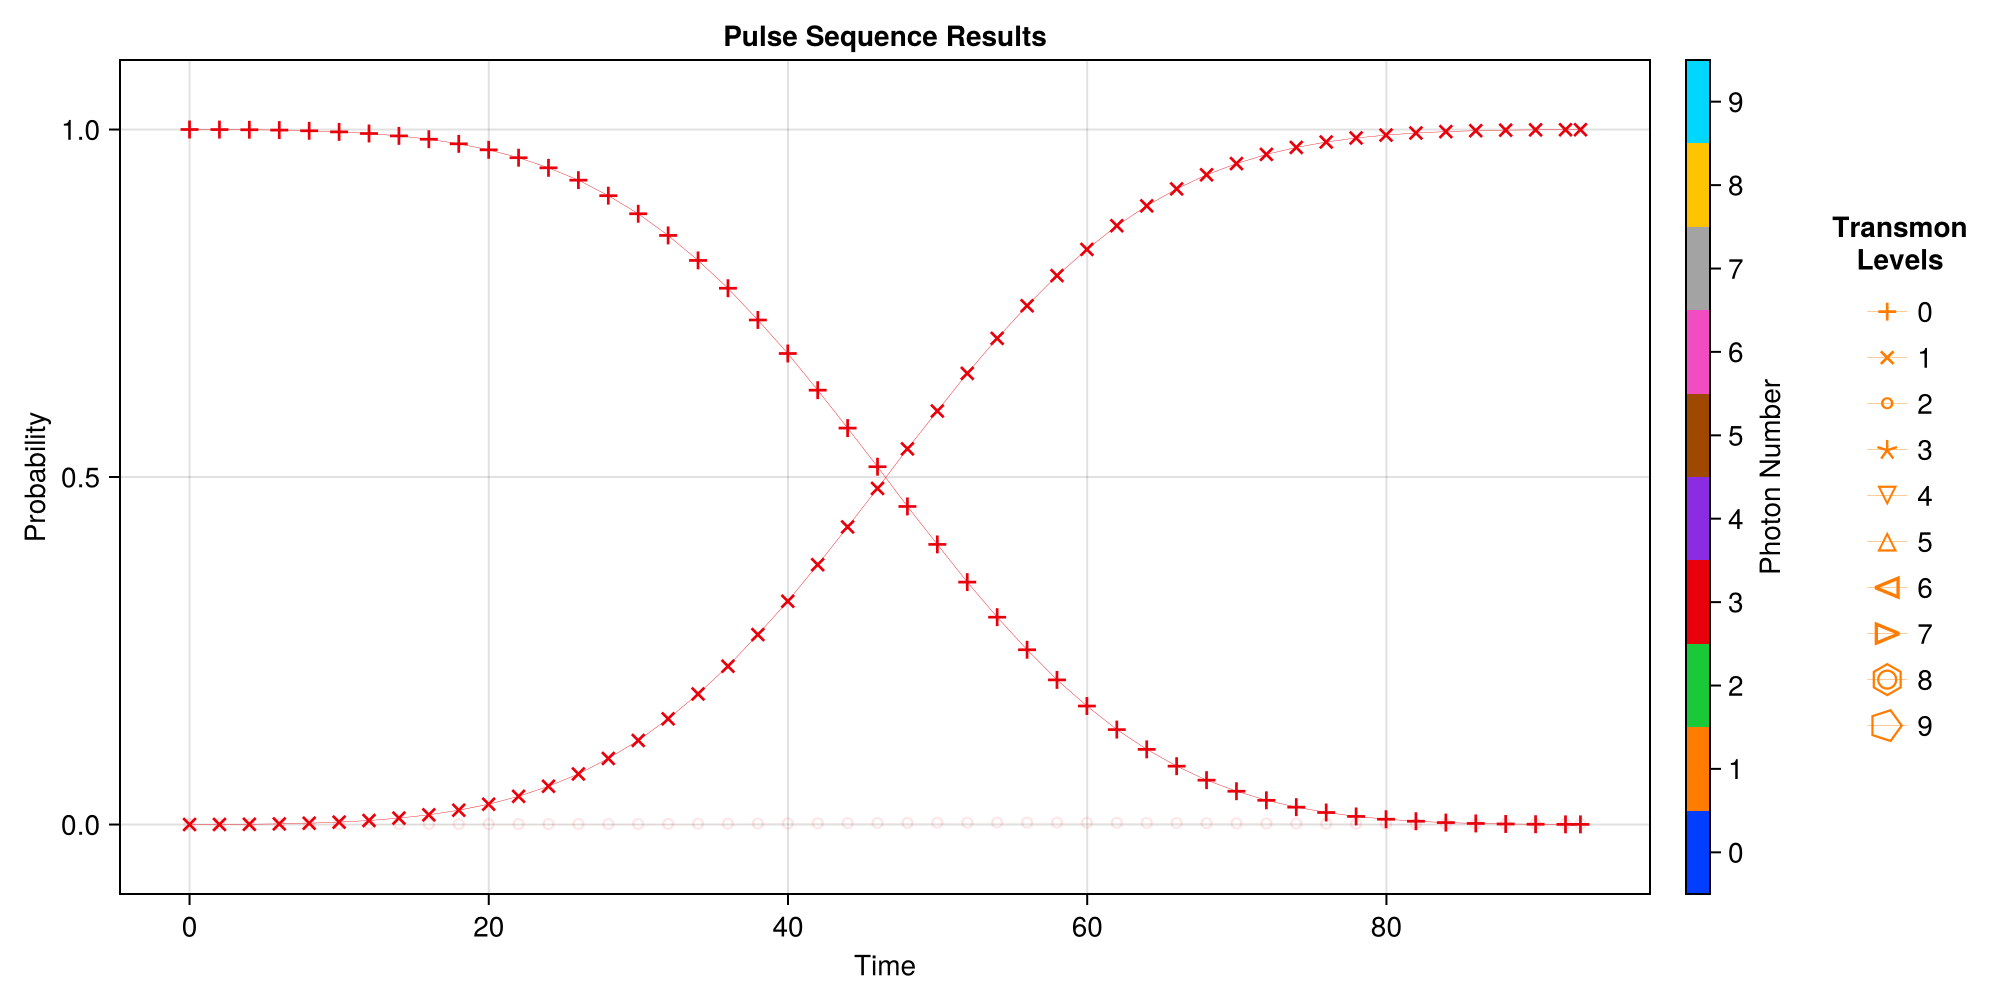

CairoMakie.Screen{IMAGE}


In [46]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, q_ge3_res["times"], EVs, plot_every = 10, emph_states = [(0,3),(1,3)])

In [47]:
EVs[(1,3)][end]

0.9997129656846394 - 1.7776422473180696e-18im

In [48]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999957309181 - 1.7735470480523674e-18im

### Guassian e -> f

In [49]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ef"]["sigma"]))

Target σ: 0.023251488095238096


##### Getting Stark Shift

[2024-11-06 20:23:53] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


[2024-11-06 20:23:57] Info: Done With Floquet Sweep
[2024-11-06 20:23:57] Info: Fit Stuff: 3-element Vector{Float64}:	 0.00016525217448376788	 0.008956158840579353	 2.0062853475301052
Stark shift res: [0.00016525217448376788, 55.65260673892846]


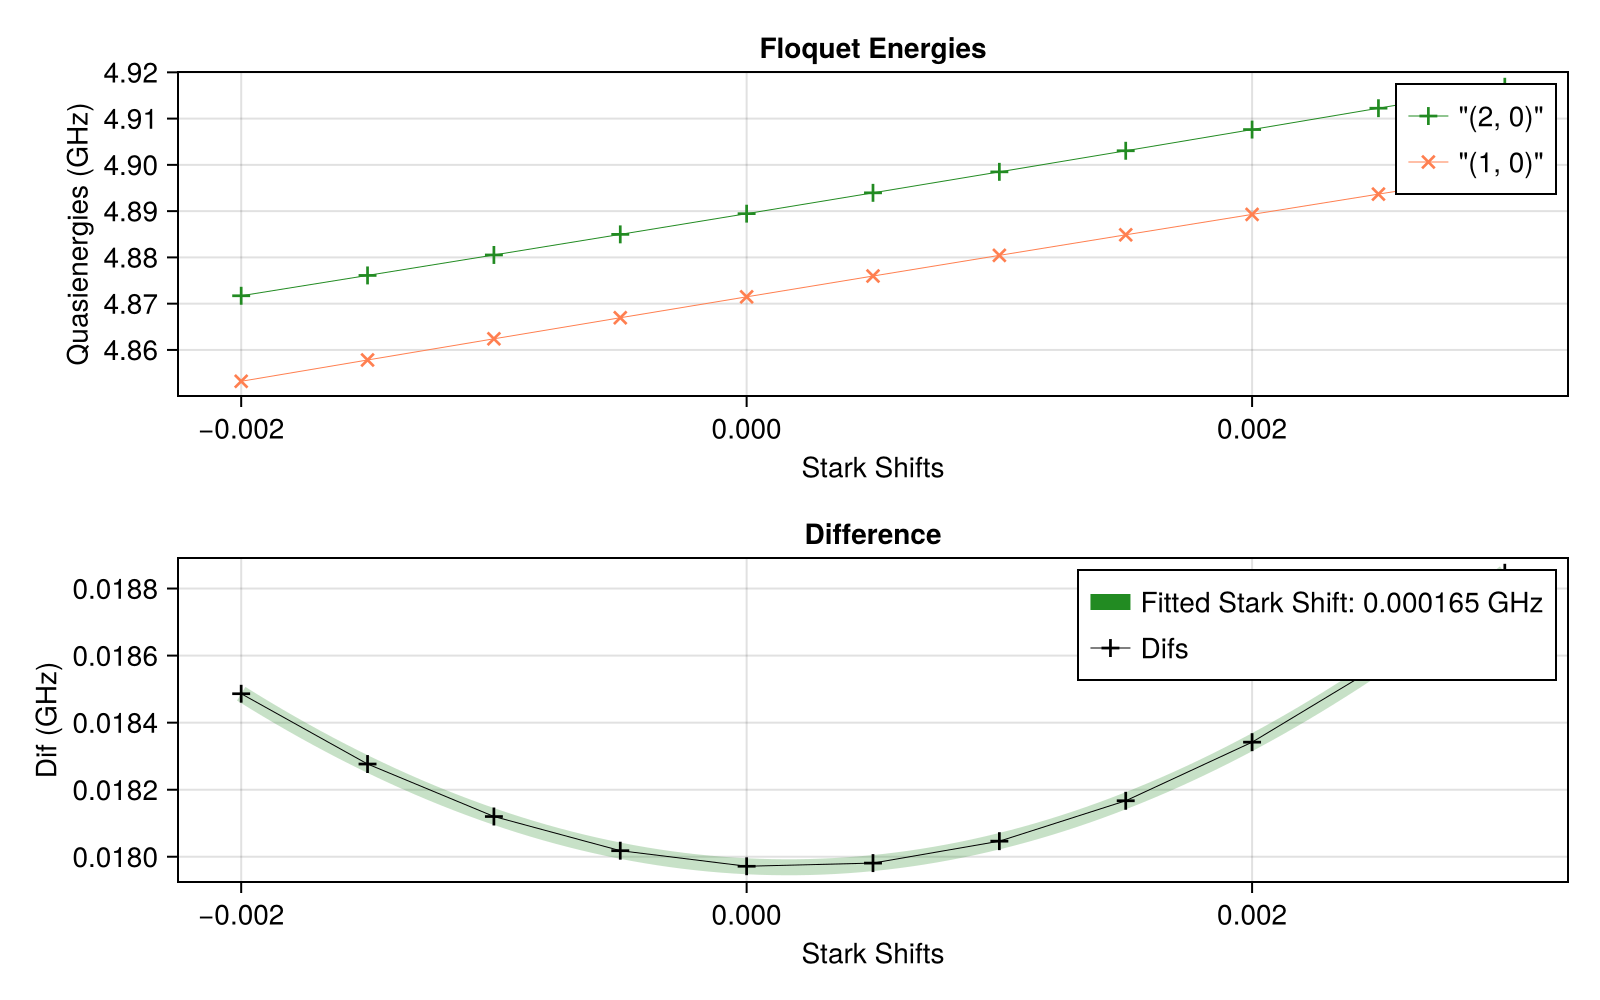

In [50]:
ef_ε = 0.00385
drive_op = Mode3.n̂ₜ
state1 = (1,0)
state2 = (2,0)

stark_shift_list = collect(LinRange(-0.002, 0.003, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode3, state1, state2, ef_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))

ef_stark_shift = stark_shift_res[1];

##### $|1,0\rangle \to |2,0\rangle$

In [51]:
state1 = (1,0)
state2 = (2,0)
ψ1 = Mode3.dressed_states[state1]
ψ2 = Mode3.dressed_states[state2]

freq_d = Mode3.dressed_energies[state2]-Mode3.dressed_energies[state1] + ef_stark_shift


envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef0_opt_res = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-06 20:23:57] Info: On Level 1
[2024-11-06 20:23:57] Info: On Step 1: t = 90.0
[2024-11-06 20:23:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:23:59] Info: Time Evolution Complete
[2024-11-06 20:23:59] Info: Done with Level_1_step_1
[2024-11-06 20:23:59] Info: Accurace: 0.9972878623742573
[2024-11-06 20:23:59] Info: ------------------------------------------------------------------------------
[2024-11-06 20:23:59] Info: On Step 2: t = 92.5
[2024-11-06 20:23:59] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:24:01] Info: Time Evolution Complete
[2024-11-06 20:24:01] Info: Done with Level_1_step_2
[2024-11-06 20:24:01] Info: Accurace: 0.999764656385534
[2024-11-06 20:24:01] Info: ------------------------------------------------------------------------------
[2024-11-06 20:24:01] Info: On S

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99983
  "freq_d"        => 4.4956

In [52]:
#Mode3.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.99983
  "freq_d"        => 4.4956

In [53]:
ψ = Mode3.dressed_states[(1,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef0_res = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["q_ef_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-06T20:24:46.624
It is being saved at: Data/
[2024-11-06 20:24:46] Info: Running operator q_ef_0
[2024-11-06 20:24:46] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-06 20:24:49] Info: Time Evolution Complete
[2024-11-06 20:24:49] Info: Saving Steps
[2024-11-06 20:24:49] Info: Done with Step_1
[2024-11-06 20:24:49] Info: Done With Running Sequence
[2024-11-06 20:24:49] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [54]:
EVs_ef0 = SC.Utils.Get_EVs(q_ef0_res["states"], proj_dict);

[2024-11-06 20:24:50] Info: Making Plot


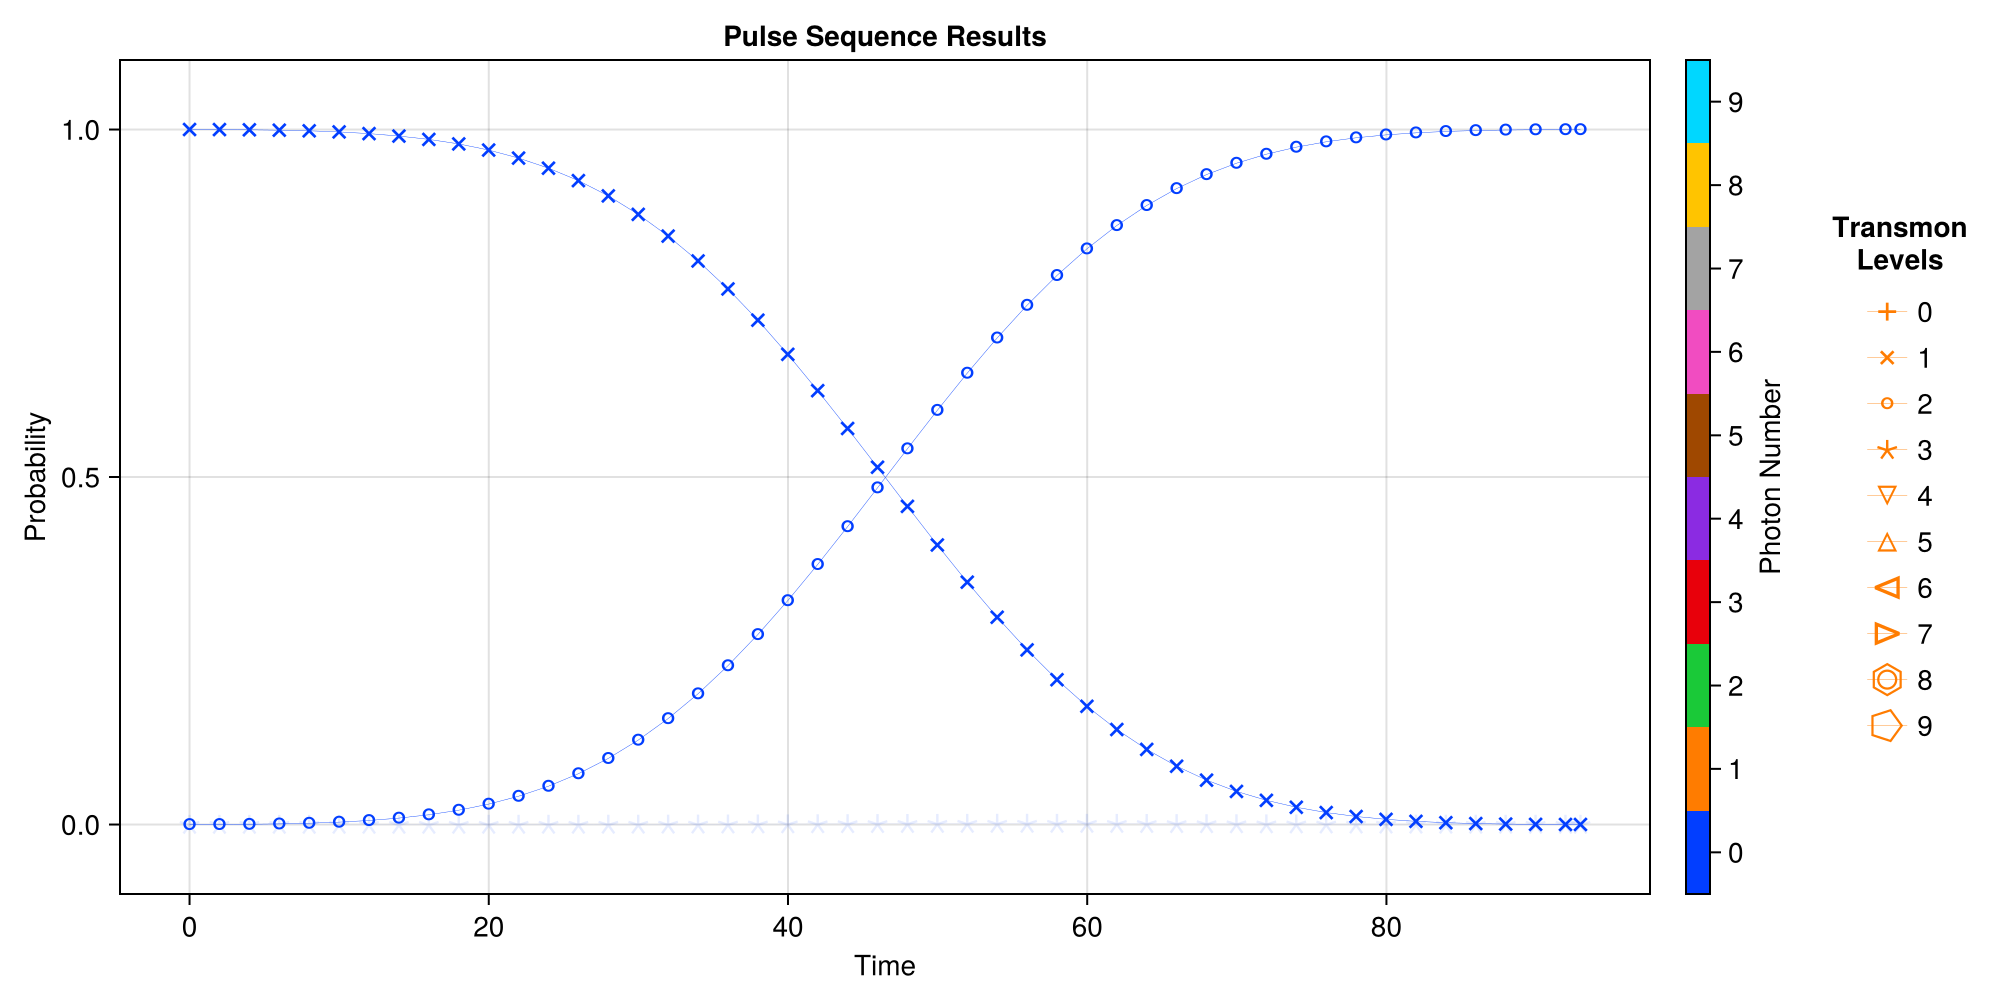

CairoMakie.Screen{IMAGE}


In [55]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, q_ef0_res["times"], EVs_ef0, plot_every = 10, emph_states = [(1,0),(2,0)])

In [56]:
println(EVs_ef0[(0,0)][end])
println(EVs_ef0[(1,0)][end])
println(EVs_ef0[(2,0)][end])
println(EVs_ef0[(3,0)][end])

1.5787559652702785e-5 + 5.929992671759138e-23im
4.688334690347721e-5 - 6.505417160266572e-21im
0.999891702420512 + 7.44480802542723e-17im
4.292388095464319e-5 + 2.961637974776039e-22im


In [57]:
tot = 0
for key in keys(EVs_ef0)
    tot+=EVs_ef0[key][end]
end
print(tot)

0.9999972974715002 + 7.454309724224773e-17im

##### $|1,1\rangle \to |2,1\rangle$

In [58]:
state1 = (1,1)
state2 = (2,1)
ψ1 = Mode3.dressed_states[state1]
ψ2 = Mode3.dressed_states[state2]

freq_d = Mode3.dressed_energies[state2]-Mode3.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef1_opt_res = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-06 20:24:50] Info: On Level 1
[2024-11-06 20:24:50] Info: On Step 1: t = 90.0
[2024-11-06 20:24:50] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:24:51] Info: Time Evolution Complete
[2024-11-06 20:24:51] Info: Done with Level_1_step_1
[2024-11-06 20:24:51] Info: Accurace: 0.9973471853491636
[2024-11-06 20:24:51] Info: ------------------------------------------------------------------------------
[2024-11-06 20:24:51] Info: On Step 2: t = 92.5
[2024-11-06 20:24:51] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:24:53] Info: Time Evolution Complete
[2024-11-06 20:24:53] Info: Done with Level_1_step_2
[2024-11-06 20:24:53] Info: Accurace: 0.999827595902493
[2024-11-06 20:24:53] Info: ------------------------------------------------------------------------------
[2024-11-06 20:24:53] Info: On S

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999893
  "freq_d"        => 4.49542

In [59]:
#Mode3.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999893
  "freq_d"        => 4.49542

In [60]:
ψ = Mode3.dressed_states[(1,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef1_res = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["q_ef_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-06T20:25:39.113
It is being saved at: Data/
[2024-11-06 20:25:39] Info: Running operator q_ef_1
[2024-11-06 20:25:39] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:25:40] Info: Time Evolution Complete
[2024-11-06 20:25:40] Info: Saving Steps
[2024-11-06 20:25:41] Info: Done with Step_1
[2024-11-06 20:25:41] Info: Done With Running Sequence
[2024-11-06 20:25:41] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [61]:
EVs = SC.Utils.Get_EVs(q_ef1_res["states"], proj_dict);

[2024-11-06 20:25:41] Info: Making Plot


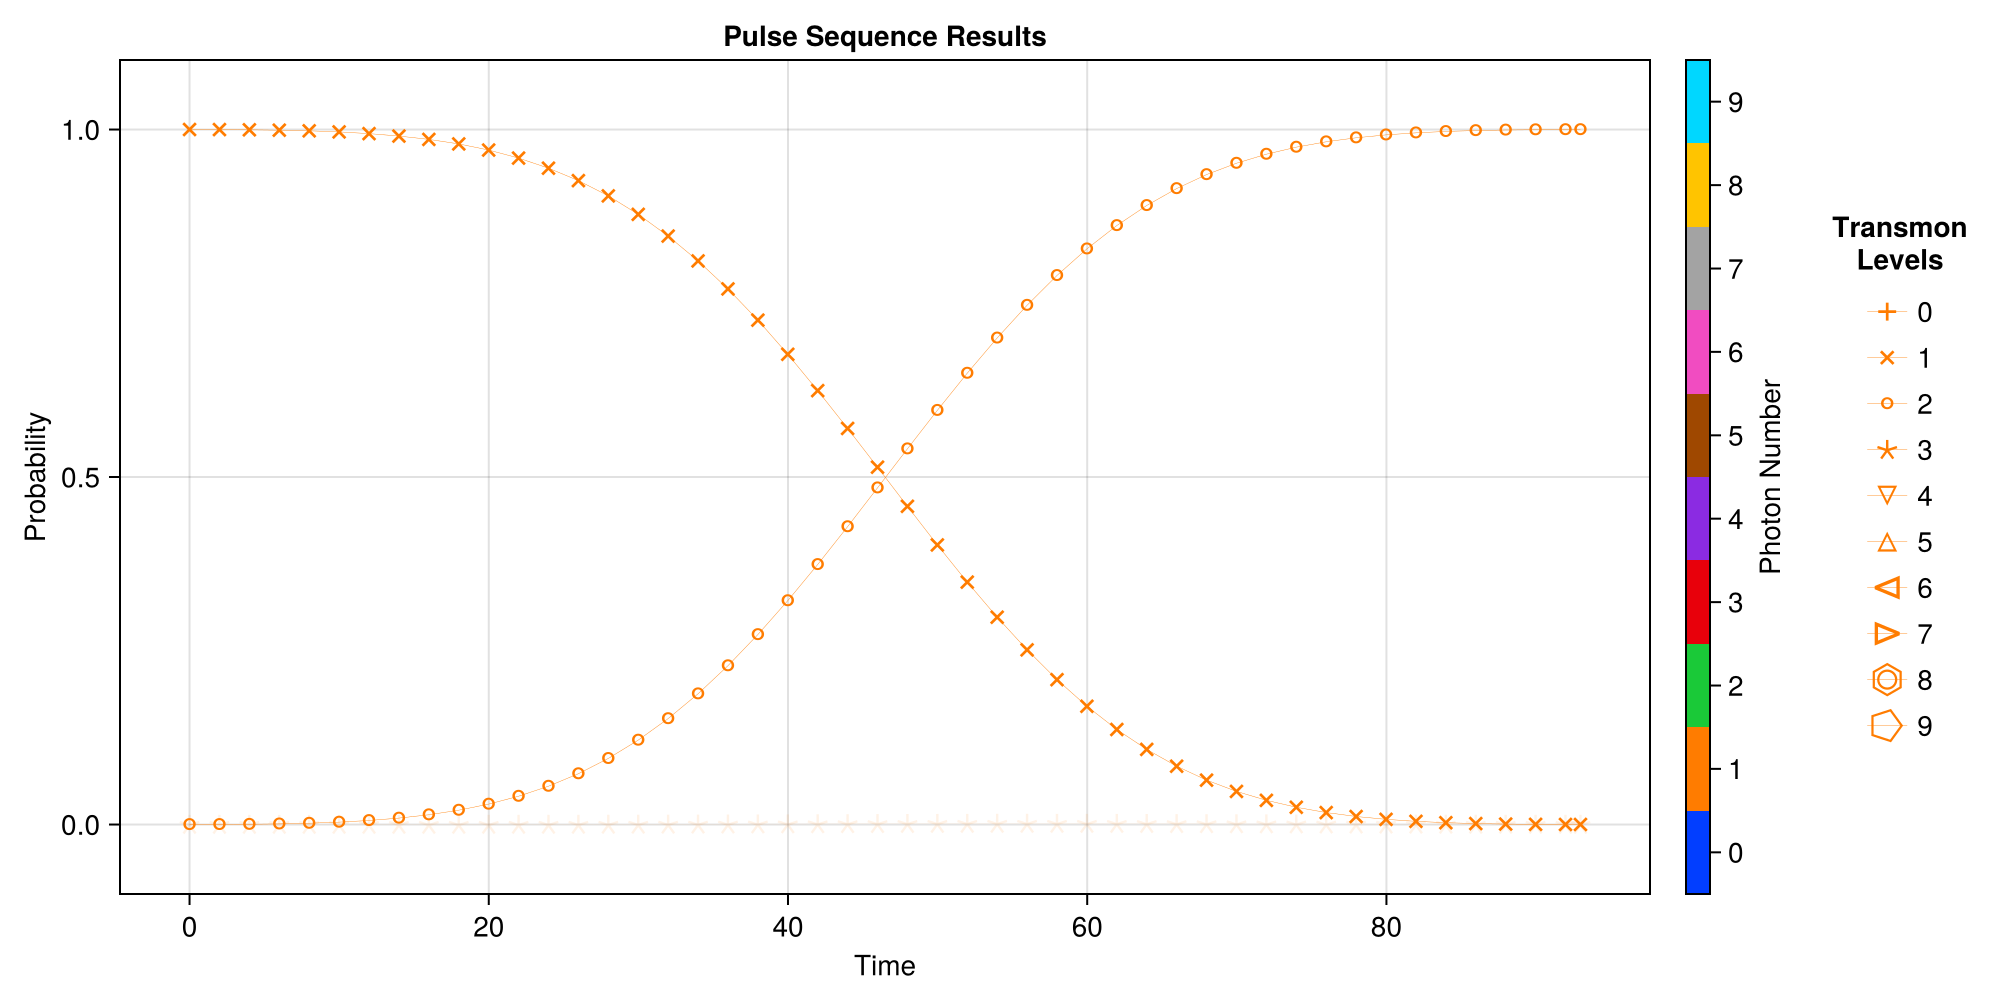

CairoMakie.Screen{IMAGE}


In [62]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, q_ef1_res["times"], EVs, plot_every = 10, emph_states = [(1,1),(2,1)])

In [63]:
EVs[(2,1)][end]

0.9998934159597105 + 4.465213123950916e-18im

In [64]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999989858041287 + 4.459365602438742e-18im

##### $|1,0\rangle+\frac{1}{\sqrt{2}}\left(|2,0\rangle + |1, 3\rangle\right)\to |2,0\rangle+\frac{1}{\sqrt{2}}\left(|1,0\rangle + |2, 3\rangle\right)$

In [65]:
ψ1 = Mode3.dressed_states[(1,0)]/sqrt(2)+Mode3.dressed_states[(2,0)]+Mode3.dressed_states[(1,3)]/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode3.dressed_states[(2,0)]+(Mode3.dressed_states[(1,0)]+Mode3.dressed_states[(2,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_ef0 = Mode3.dressed_energies[(2,0)]-Mode3.dressed_energies[(1,0)]+ef_stark_shift
freq_d_ef1 = Mode3.dressed_energies[(2,1)]-Mode3.dressed_energies[(1,1)]+ef_stark_shift
freq_d_ef3 = Mode3.dressed_energies[(2,3)]-Mode3.dressed_energies[(1,3)]+ef_stark_shift

χ = freq_d_ef1-freq_d_ef0

freq_d = freq_d_ef0+3*χ/2

check_op = proj_dict[(2,0)]+proj_dict[(1,0)]+proj_dict[(2,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ef_three_halves_opt_res = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)

[2024-11-06 20:25:41] Info: On Level 1
[2024-11-06 20:25:41] Info: On Step 1: t = 90.0
[2024-11-06 20:25:41] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-06 20:25:43] Info: Time Evolution Complete
[2024-11-06 20:25:43] Info: Done with Level_1_step_1
[2024-11-06 20:25:43] Info: Accurace: 0.9987973715766122
[2024-11-06 20:25:43] Info: ------------------------------------------------------------------------------
[2024-11-06 20:25:43] Info: On Step 2: t = 92.5
[2024-11-06 20:25:43] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-06 20:25:46] Info: Time Evolution Complete
[2024-11-06 20:25:46] Info: Done with Level_1_step_2
[2024-11-06 20:25:46] Info: Accurace: 0.9994455827661572
[2024-11-06 20:25:46] Info: ------------------------------------------------------------------------------
[2024-11-06 20:25:46] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999465
  "freq_d"        => 4.49533

In [66]:
#Mode3.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999465
  "freq_d"        => 4.49533

In [67]:
ψ = Mode3.dressed_states[(1,0)]/sqrt(2)+Mode3.dressed_states[(2,0)]+Mode3.dressed_states[(1,3)]/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ef_three_halves_res = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["q_ef_3/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-06T20:26:28.802
It is being saved at: Data/
[2024-11-06 20:26:28] Info: Running operator q_ef_3/2
[2024-11-06 20:26:28] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-06 20:26:31] Info: Time Evolution Complete
[2024-11-06 20:26:31] Info: Saving Steps
[2024-11-06 20:26:32] Info: Done with Step_1
[2024-11-06 20:26:32] Info: Done With Running Sequence
[2024-11-06 20:26:32] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [68]:
EVs = SC.Utils.Get_EVs(q_ef_three_halves_res["states"], proj_dict);

[2024-11-06 20:26:32] Info: Making Plot


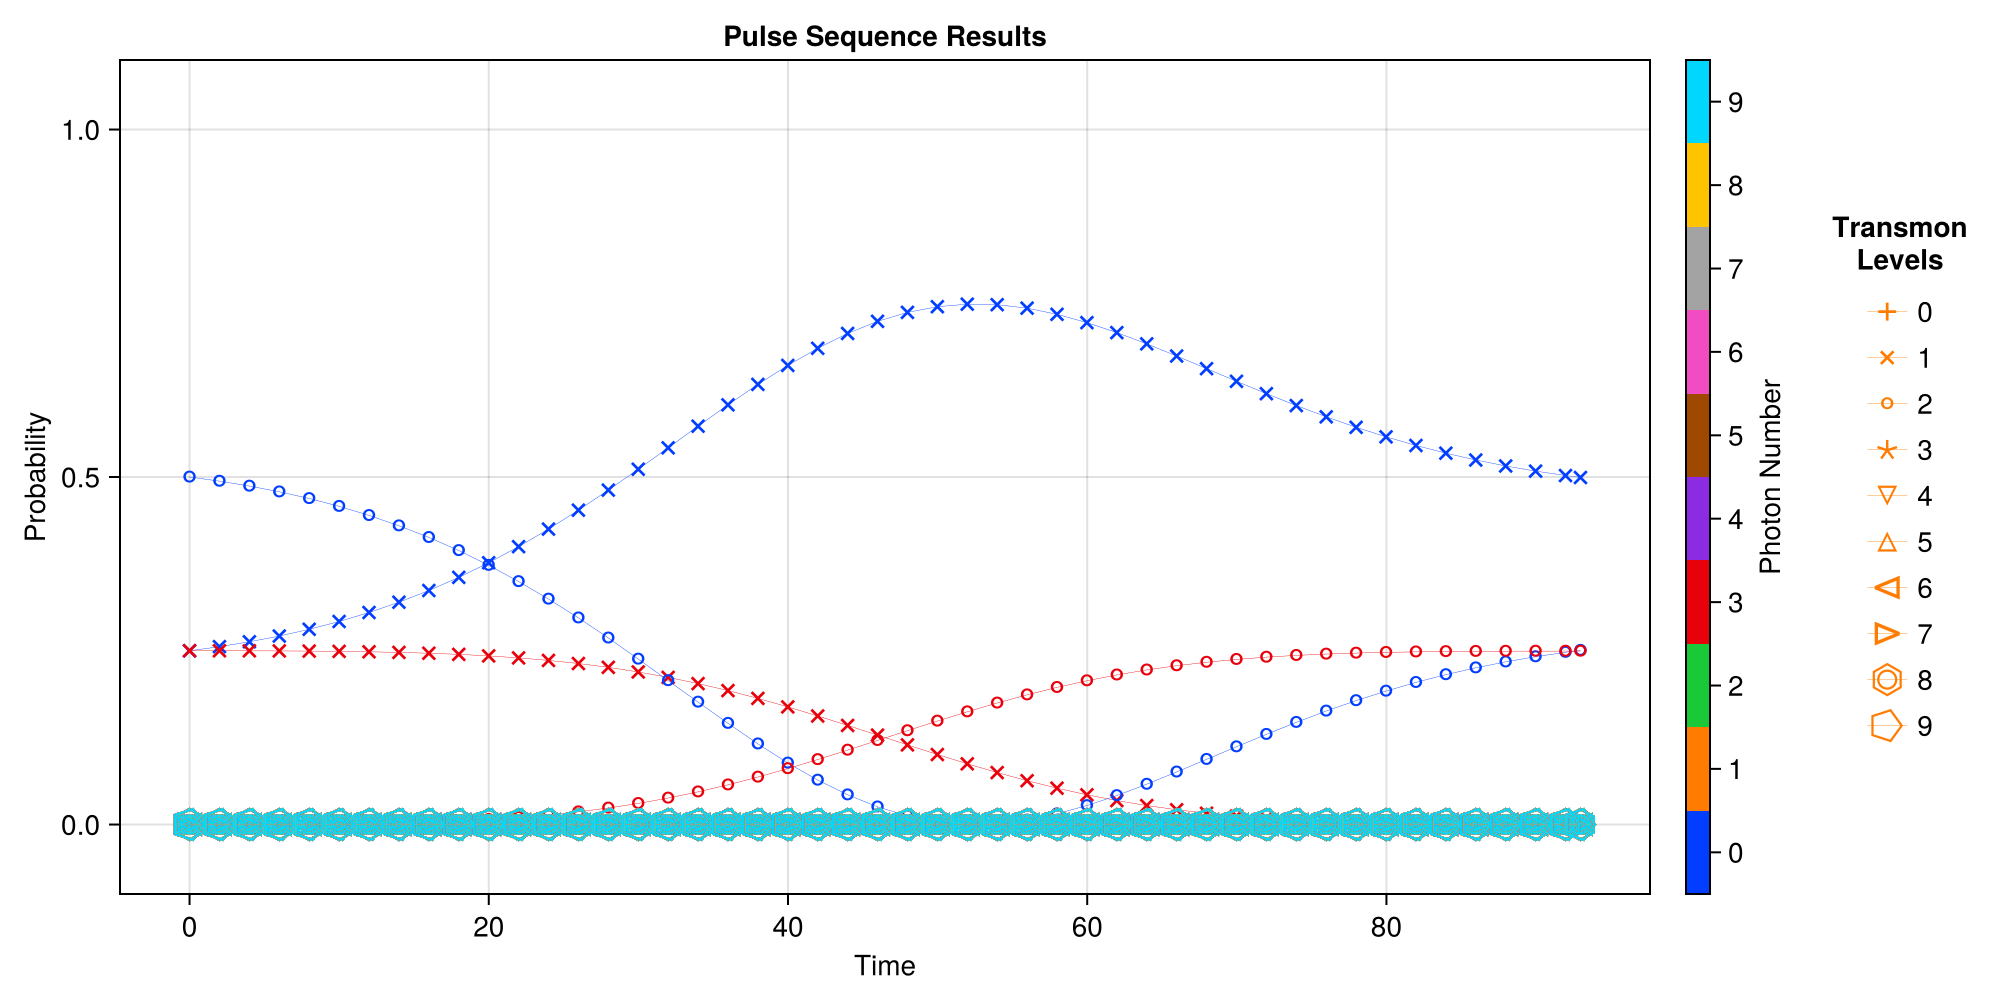

CairoMakie.Screen{IMAGE}


In [69]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, q_ef_three_halves_res["times"], EVs, plot_every = 10)

In [70]:
println(EVs[(2,0)][end])
println(EVs[(1,0)][end])
println(EVs[(2,3)][end])

0.25070089026196124 + 9.059655497492877e-18im
0.49929192923373655 - 2.2197761838700148e-17im
0.24950004652354957 - 3.259892542261815e-17im


In [71]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997236552565 - 4.622716096501529e-17im

##### $|1,2\rangle \to |2,2\rangle$

In [72]:
state1 = (1,2)
state2 = (2,2)
ψ1 = Mode3.dressed_states[state1]
ψ2 = Mode3.dressed_states[state2]

freq_d = Mode3.dressed_energies[state2]-Mode3.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef2_opt_res = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 7)


[2024-11-06 20:26:33] Info: On Level 1
[2024-11-06 20:26:33] Info: On Step 1: t = 90.0
[2024-11-06 20:26:33] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:26:34] Info: Time Evolution Complete
[2024-11-06 20:26:34] Info: Done with Level_1_step_1
[2024-11-06 20:26:34] Info: Accurace: 0.99734468772224
[2024-11-06 20:26:34] Info: ------------------------------------------------------------------------------
[2024-11-06 20:26:34] Info: On Step 2: t = 92.5
[2024-11-06 20:26:34] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:26:36] Info: Time Evolution Complete
[2024-11-06 20:26:36] Info: Done with Level_1_step_2
[2024-11-06 20:26:36] Info: Accurace: 0.9998276516071128
[2024-11-06 20:26:36] Info: ------------------------------------------------------------------------------
[2024-11-06 20:26:36] Info: On St

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49524

In [73]:
#Mode3.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49524

In [74]:
ψ = Mode3.dressed_states[(1,2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef2_res = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["q_ef_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-06T20:27:43.621
It is being saved at: Data/
[2024-11-06 20:27:43] Info: Running operator q_ef_2
[2024-11-06 20:27:43] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:27:45] Info: Time Evolution Complete
[2024-11-06 20:27:45] Info: Saving Steps
[2024-11-06 20:27:45] Info: Done with Step_1
[2024-11-06 20:27:45] Info: Done With Running Sequence
[2024-11-06 20:27:45] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [75]:
EVs = SC.Utils.Get_EVs(q_ef2_res["states"], proj_dict);

[2024-11-06 20:27:46] Info: Making Plot


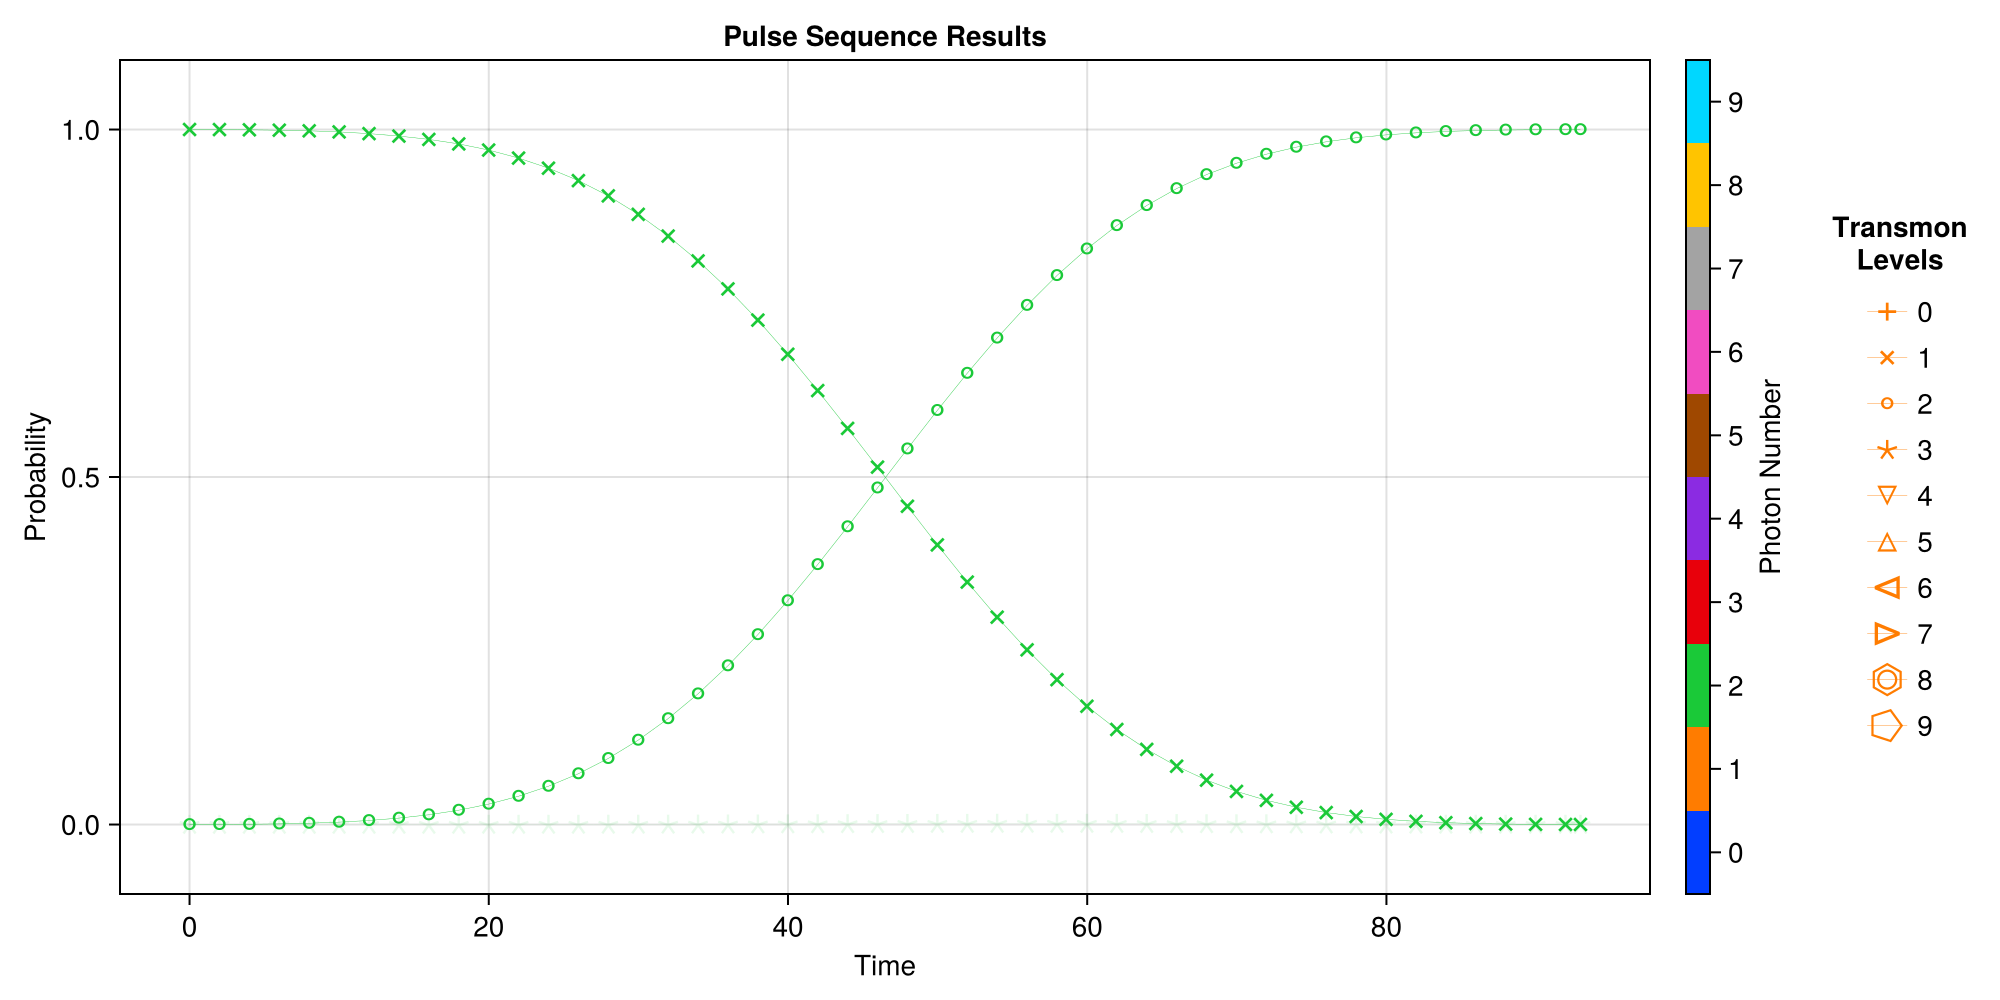

CairoMakie.Screen{IMAGE}


In [76]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, q_ef2_res["times"], EVs, plot_every = 10, emph_states = [(1,2),(2,2)])

In [77]:
EVs[(2,2)][end]

0.999894447143923 + 2.2412739514068046e-17im

In [78]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.999999994039861 + 2.3218396290566408e-17im

##### $|1,3\rangle \to |2,3\rangle$

In [79]:
state1 = (1,3)
state2 = (2,3)
ψ1 = Mode3.dressed_states[state1]
ψ2 = Mode3.dressed_states[state2]

freq_d = Mode3.dressed_energies[state2]-Mode3.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 110]

qubit_ef3_opt_res = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-06 20:27:46] Info: On Level 1
[2024-11-06 20:27:46] Info: On Step 1: t = 90.0
[2024-11-06 20:27:46] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:27:47] Info: Time Evolution Complete
[2024-11-06 20:27:47] Info: Done with Level_1_step_1
[2024-11-06 20:27:47] Info: Accurace: 0.997341591342283
[2024-11-06 20:27:47] Info: ------------------------------------------------------------------------------
[2024-11-06 20:27:47] Info: On Step 2: t = 95.0
[2024-11-06 20:27:47] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:27:49] Info: Time Evolution Complete
[2024-11-06 20:27:49] Info: Done with Level_1_step_2
[2024-11-06 20:27:49] Info: Accurace: 0.9987431963656822
[2024-11-06 20:27:49] Info: ------------------------------------------------------------------------------
[2024-11-06 20:27:49] Info: On S

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999889
  "freq_d"        => 4.49506

In [80]:
#Mode3.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999889
  "freq_d"        => 4.49506

In [81]:
ψ = Mode3.dressed_states[(1,3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef3_res = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["q_ef_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-06T20:28:36.963
It is being saved at: Data/
[2024-11-06 20:28:36] Info: Running operator q_ef_3
[2024-11-06 20:28:36] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-06 20:28:38] Info: Time Evolution Complete
[2024-11-06 20:28:38] Info: Saving Steps
[2024-11-06 20:28:39] Info: Done with Step_1
[2024-11-06 20:28:39] Info: Done With Running Sequence
[2024-11-06 20:28:39] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199839, 0.399678, 0.599517, 0.799356, 0.999195, 1.1990…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [82]:
EVs = SC.Utils.Get_EVs(q_ef3_res["states"], proj_dict);

[2024-11-06 20:28:39] Info: Making Plot


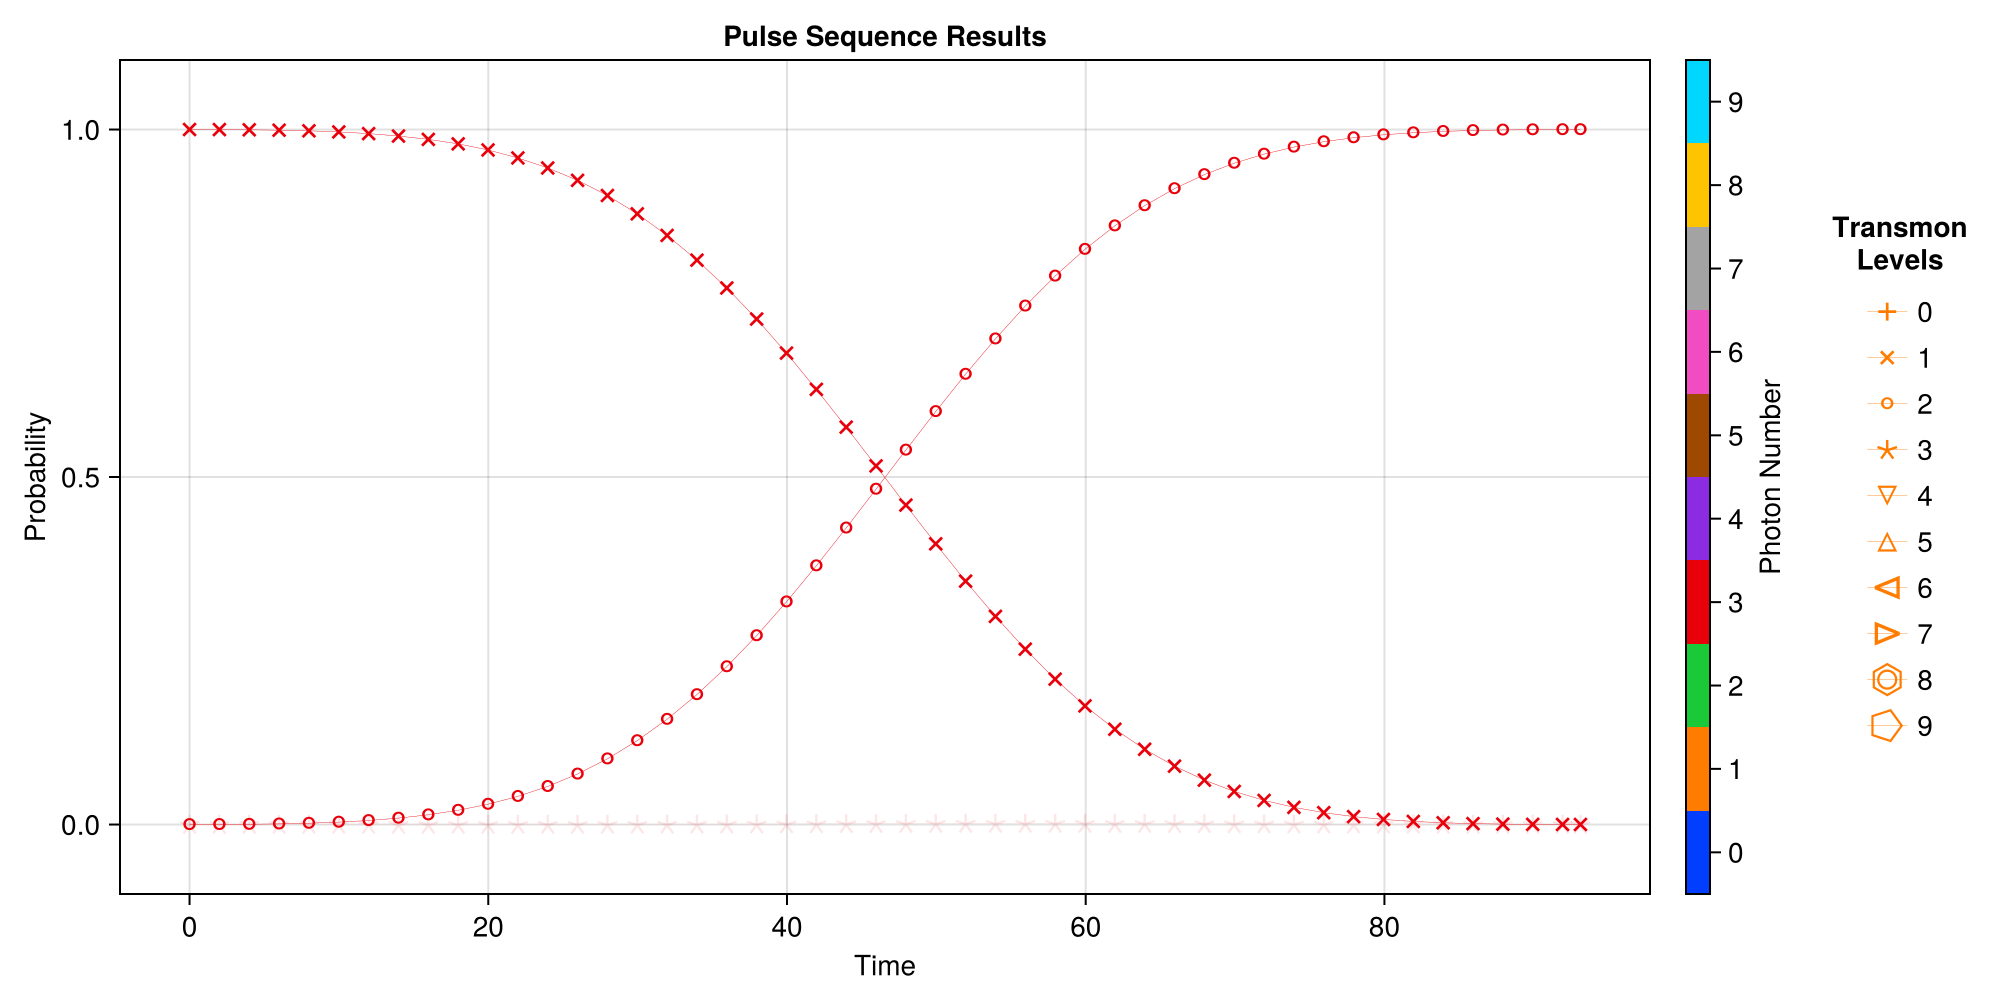

CairoMakie.Screen{IMAGE}


In [83]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, q_ef3_res["times"], EVs, plot_every = 10, emph_states = [(1,3),(2,3)])

In [84]:
EVs[(2, 3)][end]

0.9998893987560805 - 1.1050450780596055e-16im

In [85]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
tot

0.9999999999991728 - 1.1278515710112026e-16im

### Half Qubit $|g0\rangle \to |g0\rangle+|e0\rangle$

In [ ]:
starting_args = deepcopy(Mode3.Stuff["op_drive_params"]["q_ge_0"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]*0.5

ψ1 = Mode3.dressed_states[(0,0)]
ψ2 = Mode3.dressed_states[(0,0)] + Mode3.dressed_states[(1,0)]
ψ2 = ψ2/sqrt(2)

op = Mode3.dressed_states[(0,0)]*Mode3.dressed_states[(1,0)]'*2



t_range = [starting_args["pulse_time"], starting_args["pulse_time"]]


optimize_res_half_g0e0 = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 1, check_op = op)

[2024-11-07 20:13:05] Info: On Level 1
[2024-11-07 20:13:05] Info: On Step 1: t = 92.96875
[2024-11-07 20:13:05] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:13:07] Info: Time Evolution Complete
[2024-11-07 20:13:07] Info: Done with Level_1_step_1
[2024-11-07 20:13:07] Info: Accurace: 0.9995612257205976
[2024-11-07 20:13:07] Info: ------------------------------------------------------------------------------
[2024-11-07 20:13:07] Info: Highest Accuracy: 0.9995612257205976
[2024-11-07 20:13:07] Info: New ti: 92.96875, new tf: 92.96875
[2024-11-07 20:13:07] Info: ===================================================================================================	


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{String, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999561
  "freq_d"        => 4.60403

In [ ]:
#Mode3.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{String, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999561
  "freq_d"        => 4.60403

In [ ]:
ψ = Mode3.dressed_states[(0,0)]
res_half_ge0 = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["q_half_ge0"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-07T20:13:07.493
It is being saved at: Data/
[2024-11-07 20:13:07] Info: Running operator q_half_ge0
[2024-11-07 20:13:07] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:13:09] Info: Time Evolution Complete
[2024-11-07 20:13:09] Info: Saving Steps
[2024-11-07 20:13:09] Info: Done with Step_1
[2024-11-07 20:13:09] Info: Done With Running Sequence
[2024-11-07 20:13:09] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [ ]:
EVs_Dict = SC.Utils.Get_EVs(res_half_ge0["states"], proj_dict);

[2024-11-07 20:13:10] Info: Making Plot


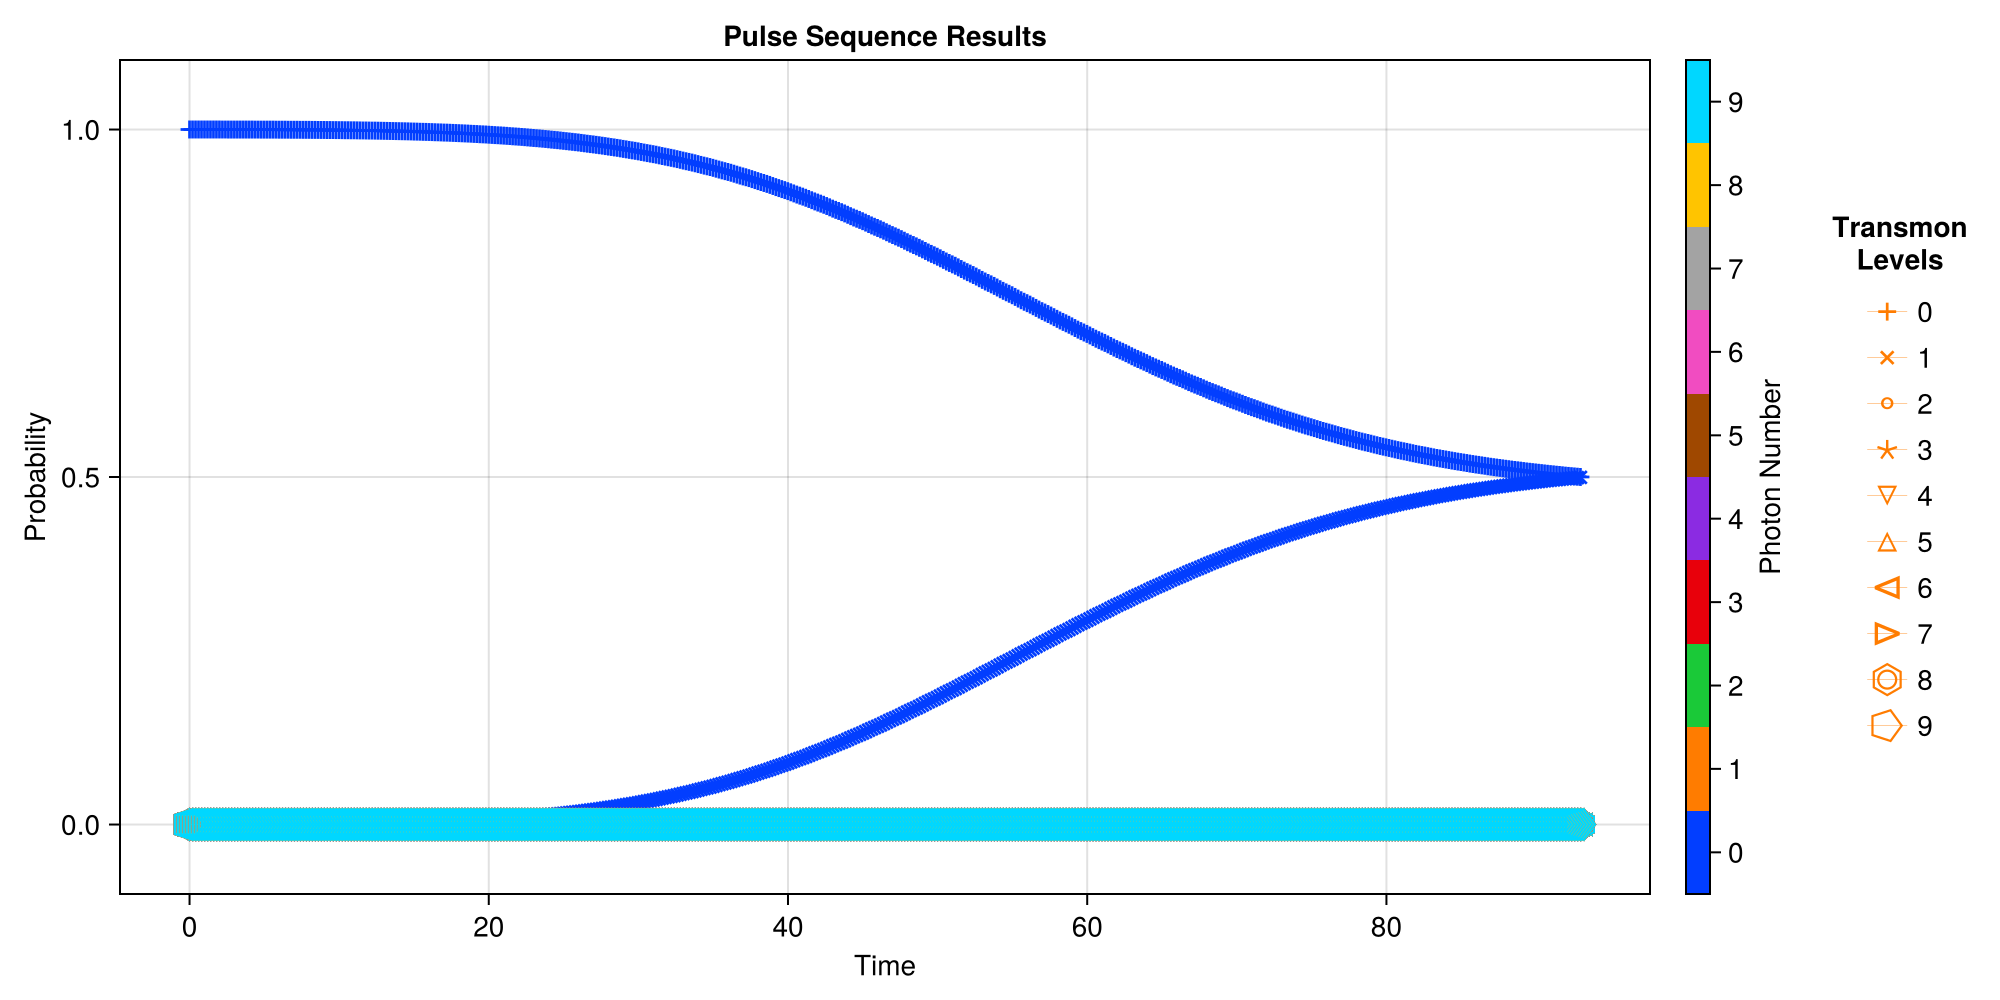

In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, res_half_ge0["times"], EVs_Dict);

In [ ]:
println(EVs_Dict[(0,0)][end])
println(EVs_Dict[(1,0)][end])

0.500072939925517 - 1.3069918819994556e-17im
0.4994884566803782 - 6.057222174739781e-18im


## Sidebands at $\varepsilon = 0.735$

### Getting Stark Shift

[2024-11-07 18:33:34] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


[2024-11-07 18:33:41] Info: Done With Floquet Sweep
[2024-11-07 18:33:41] Info: Fit Stuff: 3-element Vector{Float64}:	 0.037664663557229916	 0.0024389735332742764	 2.127683942377587
Stark shift res: [0.037664663557229916, 192.70181114244443]


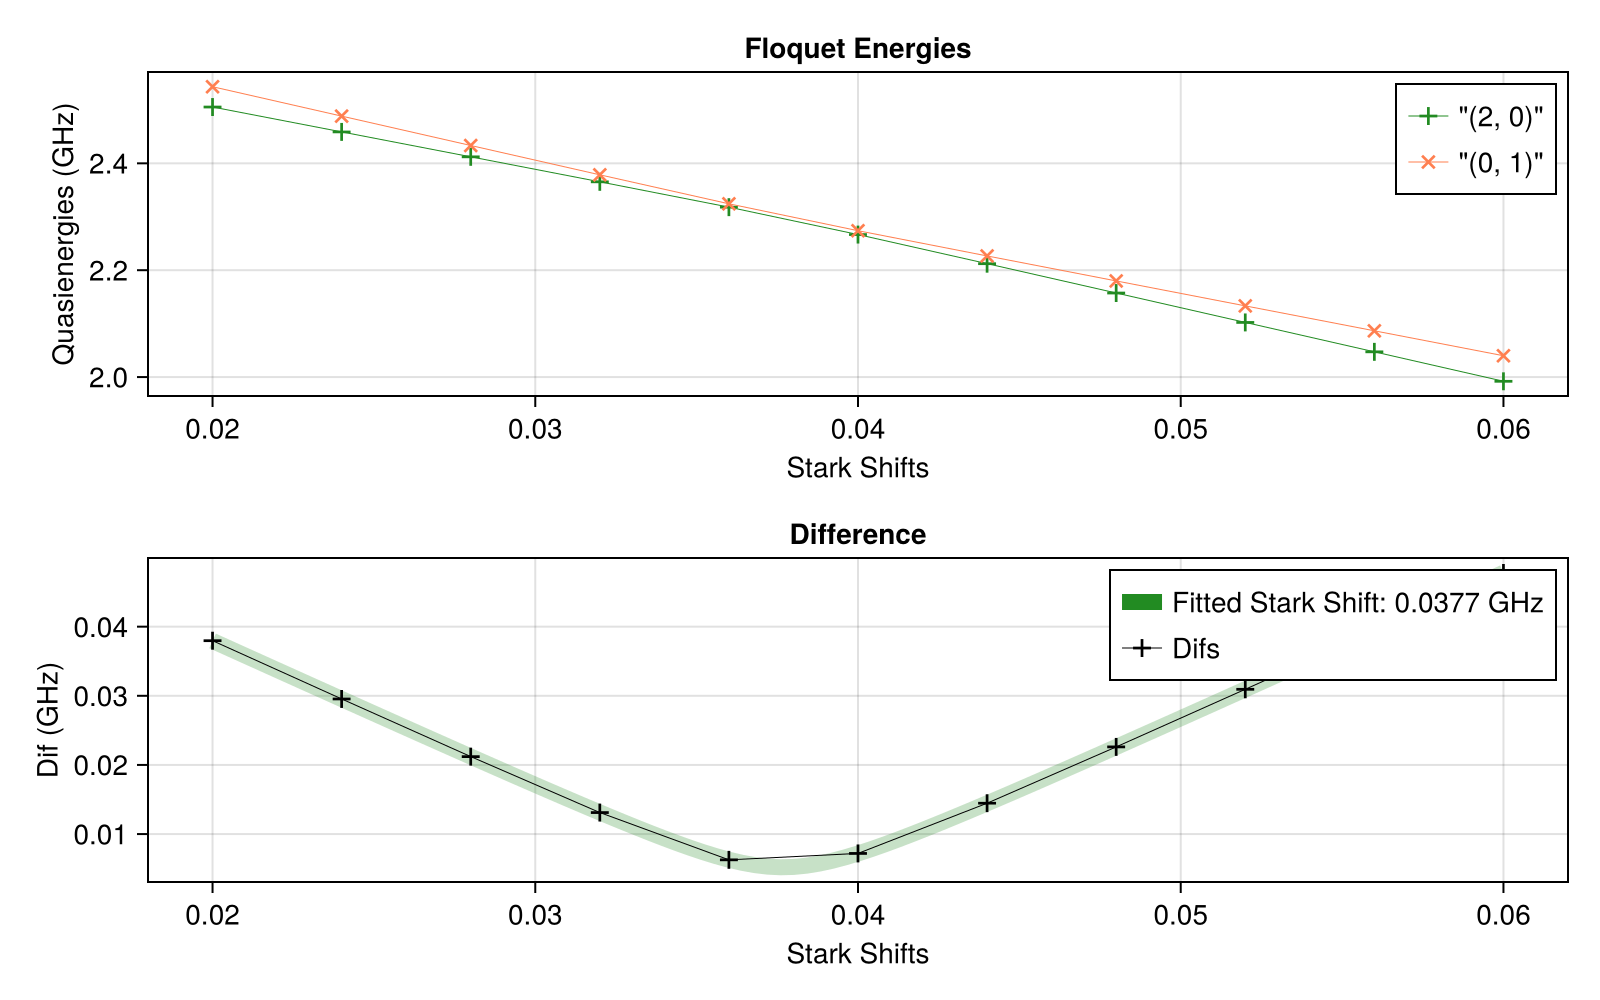

In [29]:
fngnp1_ε = 0.735
drive_op = Mode3.n̂ₜ
state1 = (2,0)
state2 = (0,1)

stark_shift_list = collect(LinRange(0.02, 0.06, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode3, state1, state2, fngnp1_ε, stark_shift_list)

println("Stark shift res: "*string(stark_shift_res))
fngnp1_stark_shift = stark_shift_res[1];
fngnp1_start_time = stark_shift_res[2];

In [30]:
fngnp1_ramp_time = 11.6257;

#### f0->g1


In [31]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][3][1]*1000))

Target flattop time: 181.36160714285714


In [32]:
ψ1 = Mode3.dressed_states[(2,0)]
ψ2 = Mode3.dressed_states[(0,1)]

freq_d = Mode3.dressed_energies[(0,1)]-Mode3.dressed_energies[(2,0)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time, fngnp1_start_time+fngnp1_ramp_time*2]

optimize_res_f0g1 = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-07 18:33:42] Info: On Level 1
[2024-11-07 18:33:42] Info: On Step 1: t = 192.70181114244443
[2024-11-07 18:33:42] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-07 18:33:45] Info: Time Evolution Complete
[2024-11-07 18:33:45] Info: Done with Level_1_step_1
[2024-11-07 18:33:45] Info: Accurace: 0.9895396605954923
[2024-11-07 18:33:45] Info: ------------------------------------------------------------------------------
[2024-11-07 18:33:45] Info: On Step 2: t = 198.51466114244442
[2024-11-07 18:33:45] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-07 18:33:50] Info: Time Evolution Complete
[2024-11-07 18:33:50] Info: Done with Level_1_step_2
[2024-11-07 18:33:50] Info: Accurace: 0.9967808784391046
[2024-11-07 18:33:50] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 205.054
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>205.054, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.735
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0376647
  "accuracy"      => 0.999605
  "freq_d"        => -2.86996

In [33]:
optimize_res_f0g1["pulse_time"]-optimize_res_f0g1["Envelope Args"]["ramp_time"]*2

181.80271739244444

In [34]:
#Mode3.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 205.054
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>205.054, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.735
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0376647
  "accuracy"      => 0.999605
  "freq_d"        => -2.86996

In [35]:
ψ = Mode3.dressed_states[(2,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
sb_f0g1_res = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["sb_f0g1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-07T18:35:33.087
It is being saved at: Data/
[2024-11-07 18:35:33] Info: Running operator sb_f0g1
[2024-11-07 18:35:33] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-11-07 18:35:38] Info: Time Evolution Complete
[2024-11-07 18:35:38] Info: Saving Steps
[2024-11-07 18:35:39] Info: Done with Step_1
[2024-11-07 18:35:39] Info: Done With Running Sequence
[2024-11-07 18:35:39] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199858, 0.399716, 0.599573, 0.799431, 0.999289, 1.1991…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [36]:
EVs_f0g1 = SC.Utils.Get_EVs(sb_f0g1_res["states"], proj_dict);

[2024-11-07 18:35:40] Info: Making Plot


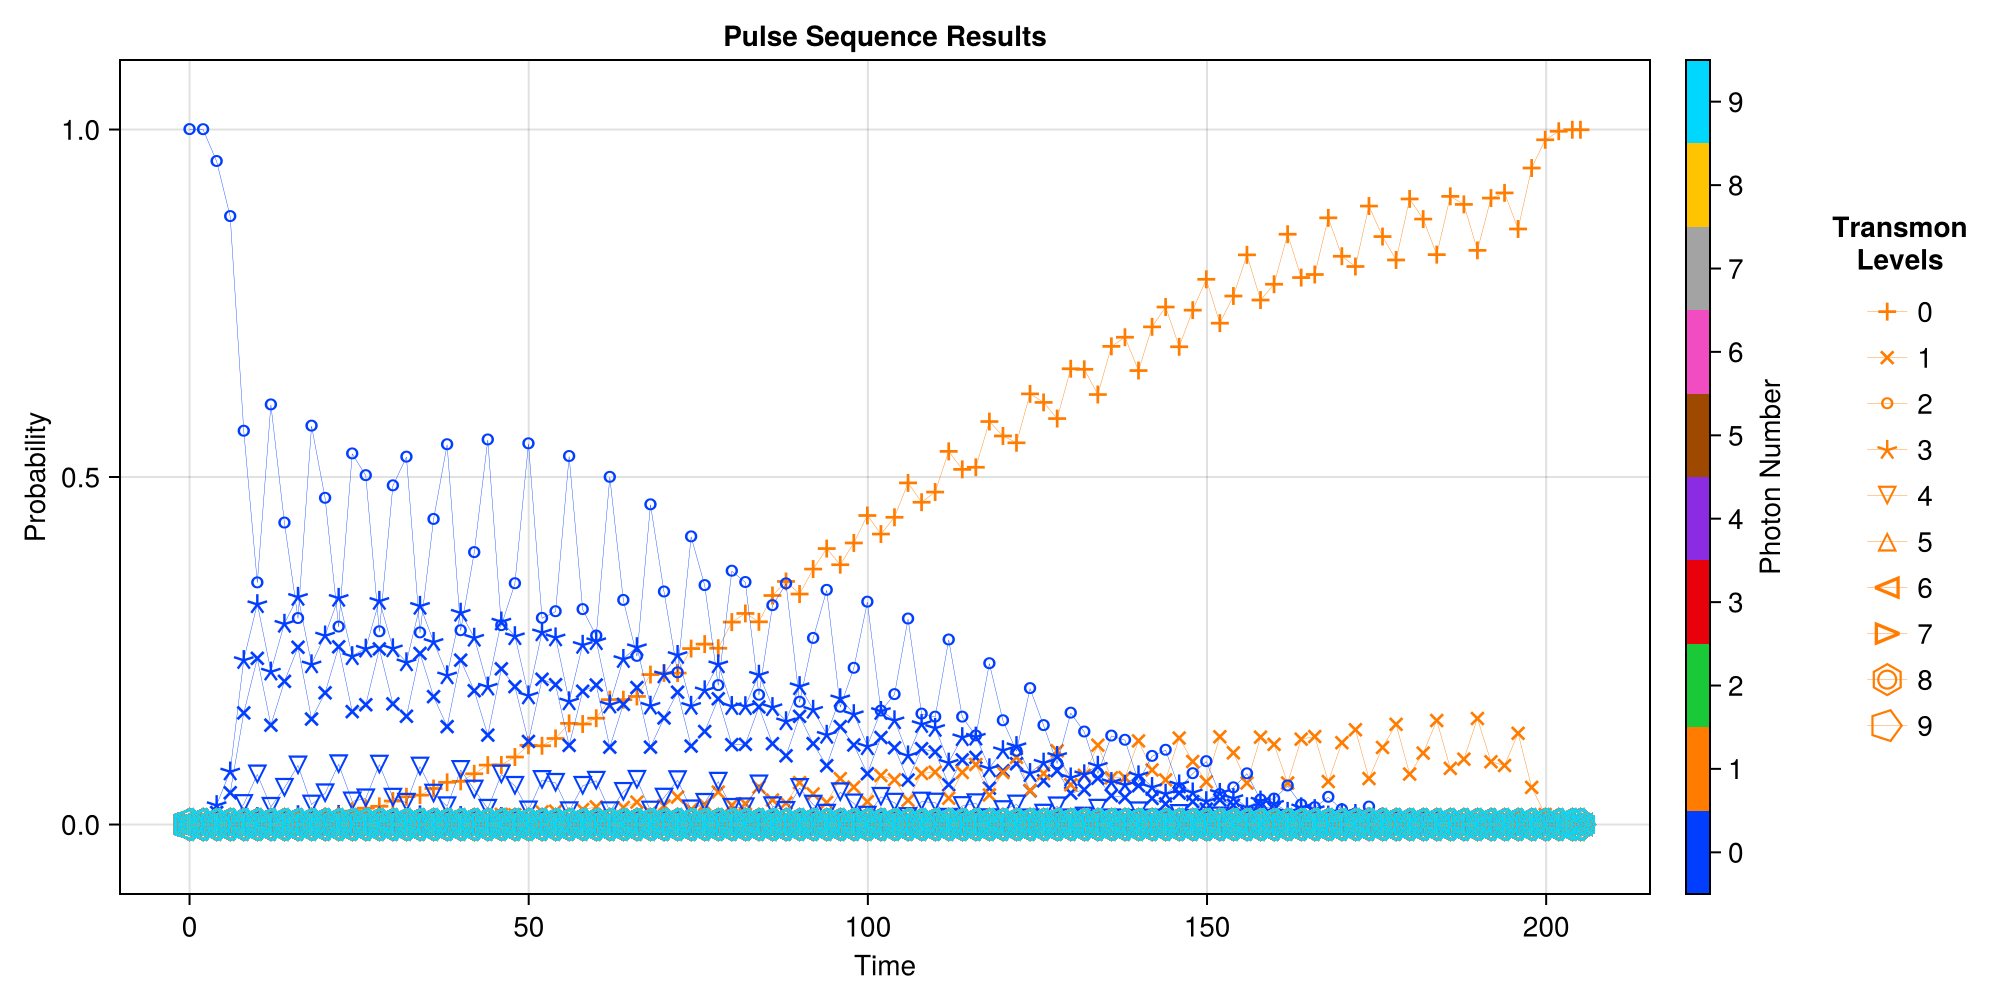

CairoMakie.Screen{IMAGE}


In [37]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, sb_f0g1_res["times"], EVs_f0g1, plot_every = 10)

#### f1->g2


In [38]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][3][2]*1000))

Target flattop time: 125.55803571428572


In [39]:
ψ1 = Mode3.dressed_states[(2,1)]
ψ2 = Mode3.dressed_states[(0,2)]

freq_d = Mode3.dressed_energies[(0,2)]-Mode3.dressed_energies[(2,1)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)


t_range = [fngnp1_start_time/sqrt(2), fngnp1_start_time/sqrt(2)+fngnp1_ramp_time*2]


optimize_res_f1g2 = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-07 18:35:55] Info: On Level 1
[2024-11-07 18:35:55] Info: On Step 1: t = 136.26075740575186
[2024-11-07 18:35:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 18:35:57] Info: Time Evolution Complete
[2024-11-07 18:35:57] Info: Done with Level_1_step_1
[2024-11-07 18:35:57] Info: Accurace: 0.9788377286873784
[2024-11-07 18:35:57] Info: ------------------------------------------------------------------------------
[2024-11-07 18:35:57] Info: On Step 2: t = 142.07360740575186
[2024-11-07 18:35:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-07 18:35:59] Info: Time Evolution Complete
[2024-11-07 18:35:59] Info: Done with Level_1_step_2
[2024-11-07 18:35:59] Info: Accurace: 0.9931970385558343
[2024-11-07 18:35:59] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 148.613
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>148.613, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.735
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0376647
  "accuracy"      => 0.998782
  "freq_d"        => -2.86958

In [40]:
optimize_res_f1g2["pulse_time"]-optimize_res_f1g2["Envelope Args"]["ramp_time"]*2

125.36166365575185

In [41]:
#Mode3.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 148.613
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>148.613, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.735
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0376647
  "accuracy"      => 0.998782
  "freq_d"        => -2.86958

#### f2->g3

In [42]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][3][3]*1000))

Target flattop time: 99.98139880952381


In [45]:
ψ1 = Mode3.dressed_states[(2,2)]
ψ2 = Mode3.dressed_states[(0,3)]

freq_d = Mode3.dressed_energies[(0,3)]-Mode3.dressed_energies[(2,2)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(3), fngnp1_start_time/sqrt(3)+fngnp1_ramp_time*2]

optimize_res_f2g3 = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-07 18:40:52] Info: On Level 1
[2024-11-07 18:40:52] Info: On Step 1: t = 111.25644253641872
[2024-11-07 18:40:52] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 18:40:54] Info: Time Evolution Complete
[2024-11-07 18:40:54] Info: Done with Level_1_step_1
[2024-11-07 18:40:54] Info: Accurace: 0.9681762963620356
[2024-11-07 18:40:54] Info: ------------------------------------------------------------------------------
[2024-11-07 18:40:54] Info: On Step 2: t = 117.06929253641871
[2024-11-07 18:40:54] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 18:40:55] Info: Time Evolution Complete
[2024-11-07 18:40:55] Info: Done with Level_1_step_2
[2024-11-07 18:40:55] Info: Accurace: 0.9895721485481237
[2024-11-07 18:40:55] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 123.609
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>123.609, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.735
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0376647
  "accuracy"      => 0.997903
  "freq_d"        => -2.86919

In [46]:
optimize_res_f2g3["pulse_time"]-optimize_res_f2g3["Envelope Args"]["ramp_time"]*2

100.35734878641871

In [48]:
#Mode3.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 123.609
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>123.609, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.735
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0376647
  "accuracy"      => 0.997903
  "freq_d"        => -2.86919

#### f3->g4

In [49]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][3][4]*1000))

Target flattop time: 86.03050595238095


In [50]:
ψ1 = Mode3.dressed_states[(2,3)]
ψ2 = Mode3.dressed_states[(0,4)]

freq_d = Mode3.dressed_energies[(0,4)]-Mode3.dressed_energies[(2,3)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(4), fngnp1_start_time/sqrt(4)+fngnp1_ramp_time*2]

optimize_res_f3g4 = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-07 18:43:55] Info: On Level 1
[2024-11-07 18:43:55] Info: On Step 1: t = 96.35090557122221
[2024-11-07 18:43:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 18:43:57] Info: Time Evolution Complete
[2024-11-07 18:43:57] Info: Done with Level_1_step_1
[2024-11-07 18:43:57] Info: Accurace: 0.9575931005846268
[2024-11-07 18:43:57] Info: ------------------------------------------------------------------------------
[2024-11-07 18:43:57] Info: On Step 2: t = 102.16375557122223
[2024-11-07 18:43:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 18:43:58] Info: Time Evolution Complete
[2024-11-07 18:43:58] Info: Done with Level_1_step_2
[2024-11-07 18:43:58] Info: Accurace: 0.9859496415568408
[2024-11-07 18:43:58] Info: ------------------------------------------------------------------------------
[202

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 108.703
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>108.703, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.735
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0376647
  "accuracy"      => 0.997015
  "freq_d"        => -2.86881

In [53]:
optimize_res_f3g4["pulse_time"]-optimize_res_f3g4["Envelope Args"]["ramp_time"]*2

85.45181182122222

In [54]:
#Mode3.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 108.703
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>108.703, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.735
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0376647
  "accuracy"      => 0.997015
  "freq_d"        => -2.86881

## Other Specific Gates

### Special Side Bands

#### f1_2pi_g3

##### Getting Drive Strength and Stark Shift

In [87]:
n1 = 1
n2 = 3

freq1 = Mode3.dressed_energies[(2,n1)]-Mode3.dressed_energies[(0,n1+1)]
freq2 = Mode3.dressed_energies[(2,n2)]-Mode3.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f1_2pi_g3 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.4
println("Required Epsilon: $eps_f1_2pi_g3")

χ: 0.0007696601981166395
m: 1.4142135623730951
n: 1
Required Epsilon: 0.1088463890595315


[2024-11-07 19:01:48] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


[2024-11-07 19:01:55] Info: Done With Floquet Sweep
[2024-11-07 19:01:55] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0008612307241386342	 0.00055570241680817	 2.0029025738633695


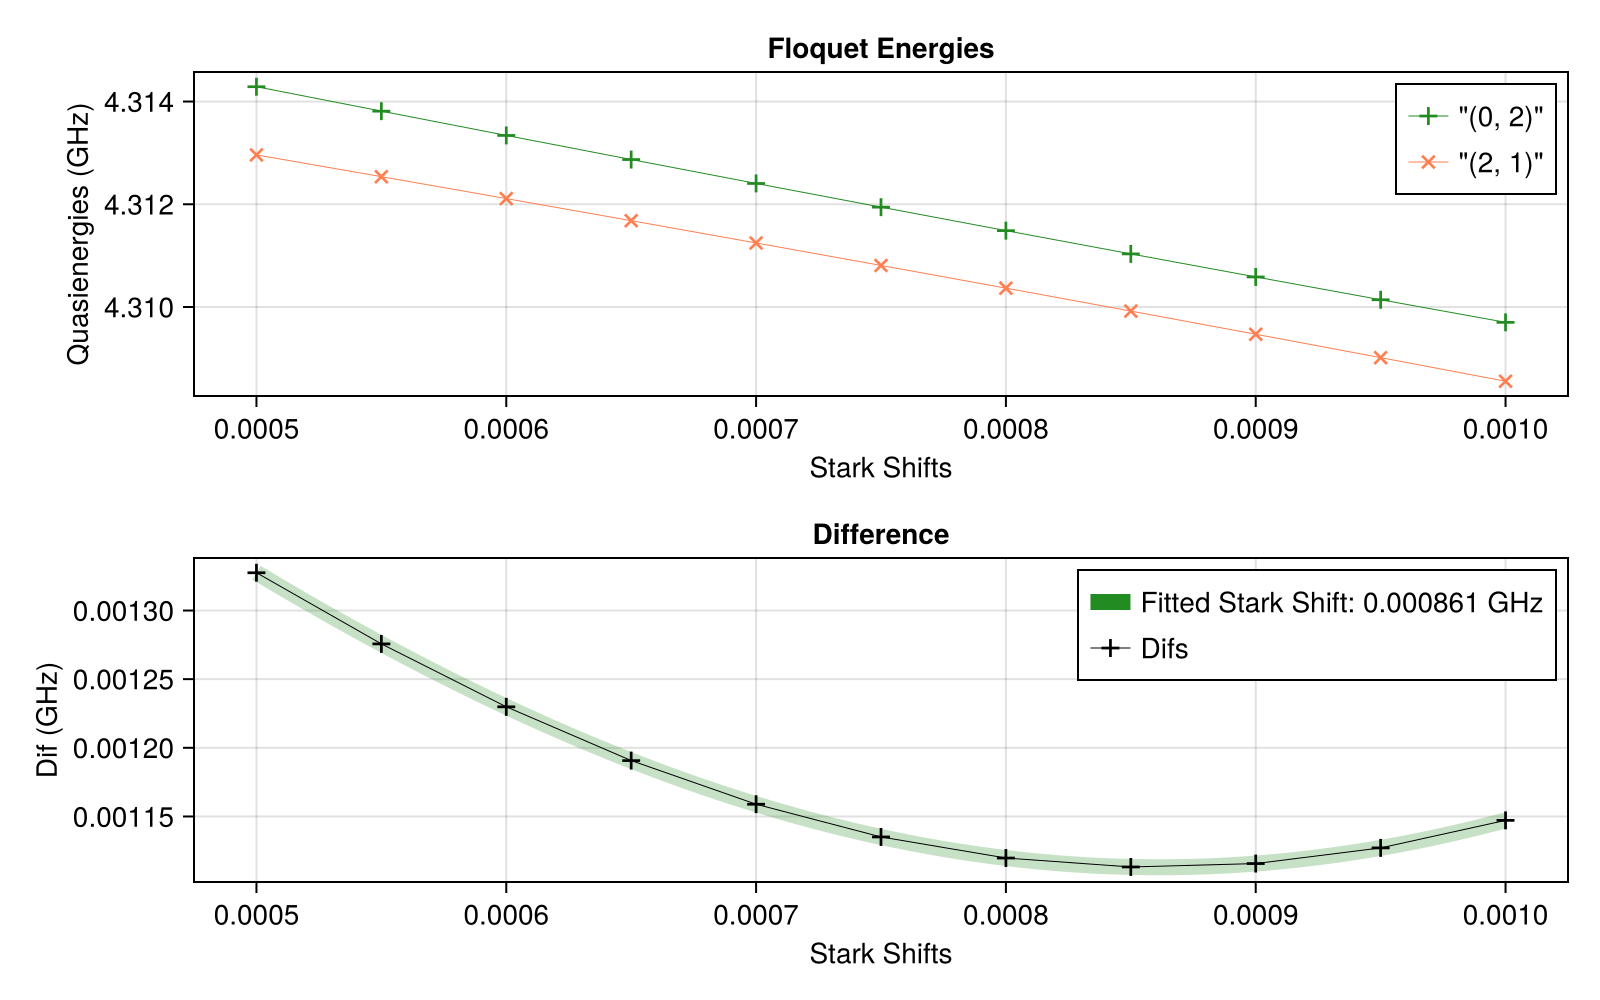

2-element Vector{Float64}:
   0.0008612307241386342
 898.4582269636376

In [88]:
ε = eps_f1_2pi_g3
drive_op = Mode3.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

#stark_shift_list = collect(LinRange(0.0005, 0.002, 11))
stark_shift_list = collect(LinRange(0.0005, 0.001, 11))

stark_shift_res_f0_2pi_g3 = SC.Dynamics.FindStarkShift(Mode3, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [89]:
ψ1 = Mode3.dressed_states[(2,n1)]
ψ2 = Mode3.dressed_states[(0,n1+1)]

freq_d = Mode3.dressed_energies[(0,n1+1)]-Mode3.dressed_energies[(2, n1)]

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)


stark_shift = stark_shift_res_f0_2pi_g3[1]
initial_time = stark_shift_res_f0_2pi_g3[2]

t_range = [initial_time, initial_time+2*ramp_time]

optimize_res_f1g2_2pi_f3g4 = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, eps_f1_2pi_g3, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1)

[2024-11-07 19:02:11] Info: On Level 1
[2024-11-07 19:02:11] Info: On Step 1: t = 898.4582269636376
[2024-11-07 19:02:11] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 20s (ETA: 0h 00m 00s)
[2024-11-07 19:02:31] Info: Time Evolution Complete
[2024-11-07 19:02:31] Info: Done with Level_1_step_1
[2024-11-07 19:02:31] Info: Accurace: 0.9995722429142984
[2024-11-07 19:02:31] Info: ------------------------------------------------------------------------------
[2024-11-07 19:02:31] Info: On Step 2: t = 904.2710769636376
[2024-11-07 19:02:31] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 23s (ETA: 0h 00m 00s)
[2024-11-07 19:02:54] Info: Time Evolution Complete
[2024-11-07 19:02:54] Info: Done with Level_1_step_2
[2024-11-07 19:02:54] Info: Accurace: 0.9998888186840483
[2024-11-07 19:02:54] Info: ------------------------------------------------------------------------------
[2024

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 910.084
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>910.084, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.108846
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000861231
  "accuracy"      => 0.999999
  "freq_d"        => -2.86958

In [90]:
optimize_res_f1g2_2pi_f3g4["pulse_time"] - optimize_res_f1g2_2pi_f3g4["Envelope Args"]["ramp_time"]*2

886.8325269636376

In [91]:
#Mode3.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 910.084
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>910.084, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.108846
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000861231
  "accuracy"      => 0.999999
  "freq_d"        => -2.86958

In [92]:
ψ = Mode3.dressed_states[(2,1)]+Mode3.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f1g2_2pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["sb_f1g2_2pi_f3g4"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-07T19:04:17.845
It is being saved at: Data/
[2024-11-07 19:04:17] Info: Running operator sb_f1g2_2pi_f3g4
[2024-11-07 19:04:17] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 17s (ETA: 0h 00m 00s)
[2024-11-07 19:04:34] Info: Time Evolution Complete
[2024-11-07 19:04:34] Info: Saving Steps
[2024-11-07 19:04:36] Info: Done with Step_1
[2024-11-07 19:04:36] Info: Done With Running Sequence
[2024-11-07 19:04:36] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199974, 0.399949, 0.599923, 0.799898, 0.999872, 1.1998…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [94]:
EVs_Dict = SC.Utils.Get_EVs(res_f1g2_2pi_f3g4["states"], proj_dict);

[2024-11-07 19:04:39] Info: Making Plot


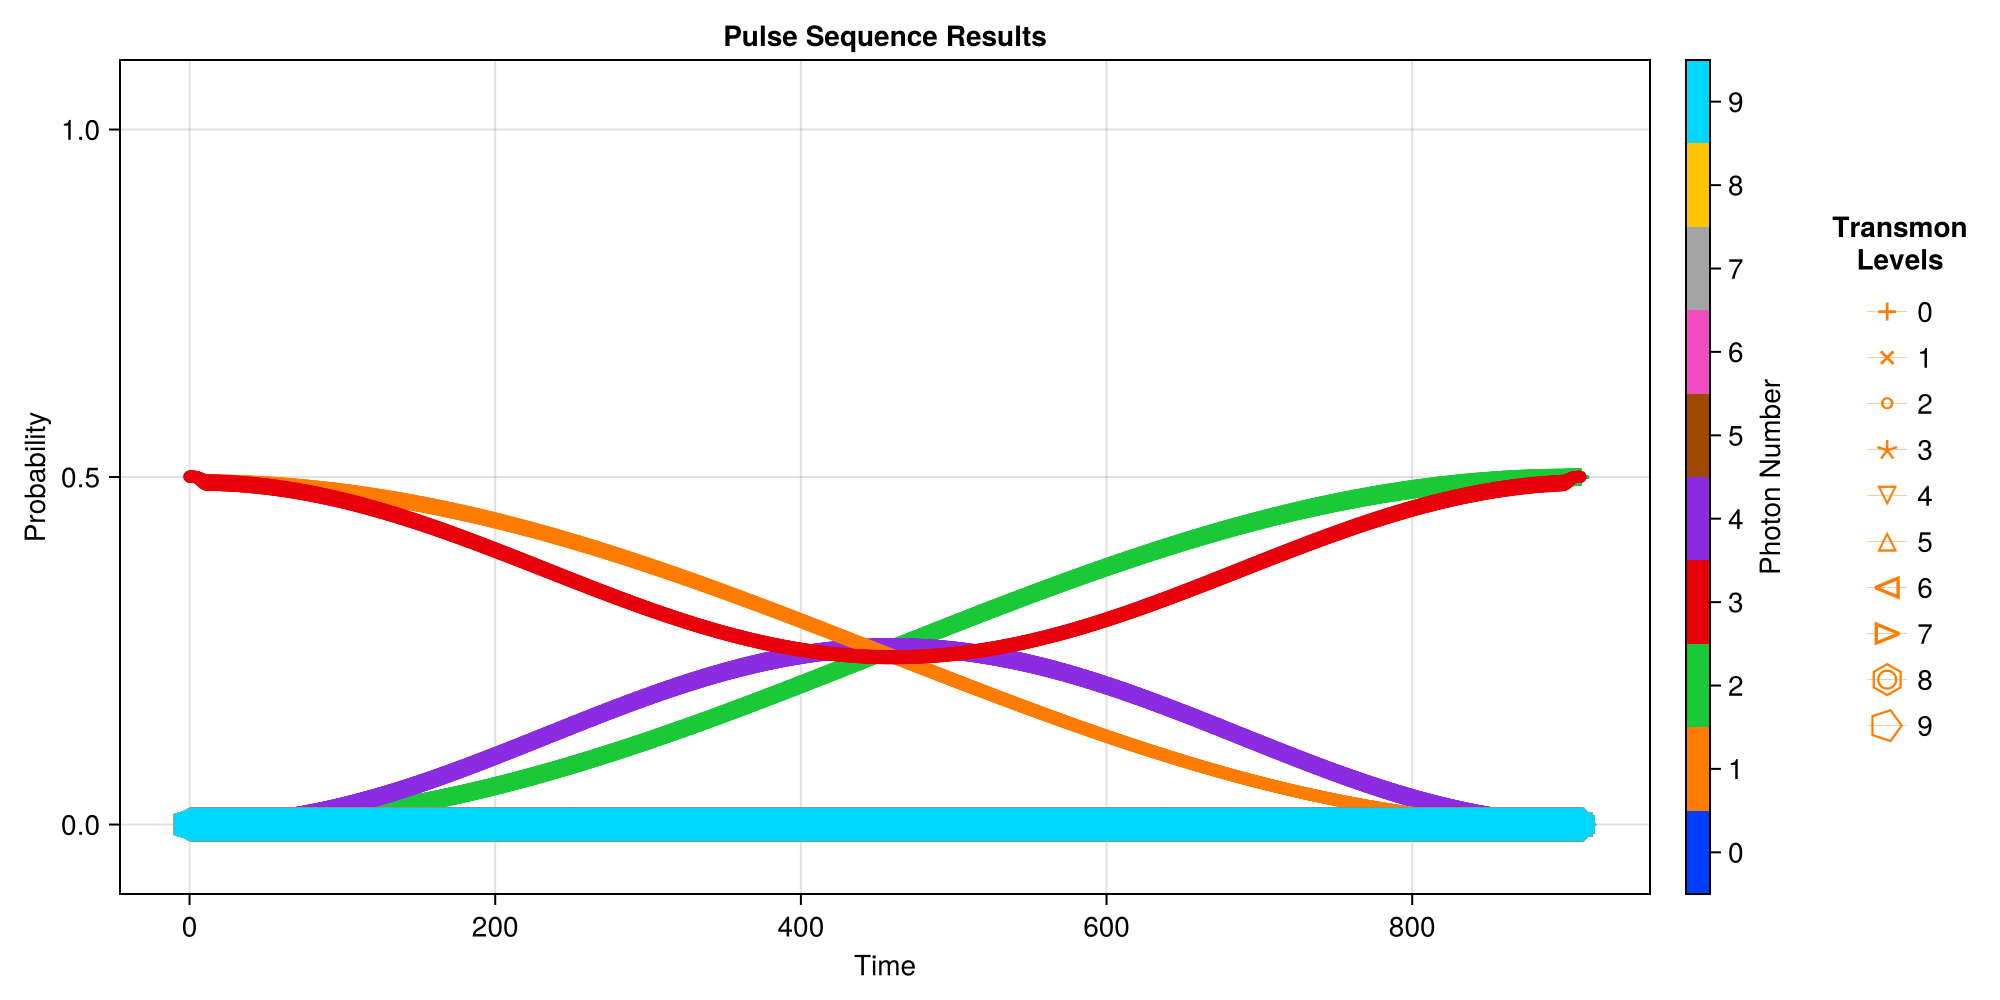

CairoMakie.Screen{IMAGE}


In [93]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, res_f1g2_2pi_f3g4["times"], EVs_Dict)

In [95]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,2)][end])

0.4996412461060635 + 1.2654872665407929e-17im
0.49999899378332435 + 8.39586619055436e-17im


#### f0_4pi_g3

##### Getting Drive Strength and Stark Shift

In [96]:
n1 = 0
n2 = 3

freq1 = Mode3.dressed_energies[(2,n1)]-Mode3.dressed_energies[(0,n1+1)]
freq2 = Mode3.dressed_energies[(2,n2)]-Mode3.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f0g1_4pi_f3g4 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.56
println("Required Epsilon: $eps_f0g1_4pi_f3g4")

χ: 0.0011546007495013555
m: 2.0000000000000004
n: 2
Required Epsilon: 0.0933252674943612


[2024-11-07 19:05:01] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


[2024-11-07 19:05:07] Info: Done With Floquet Sweep
[2024-11-07 19:05:07] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0006339817019192669	 0.00033718233879673193	 2.0021320255077675


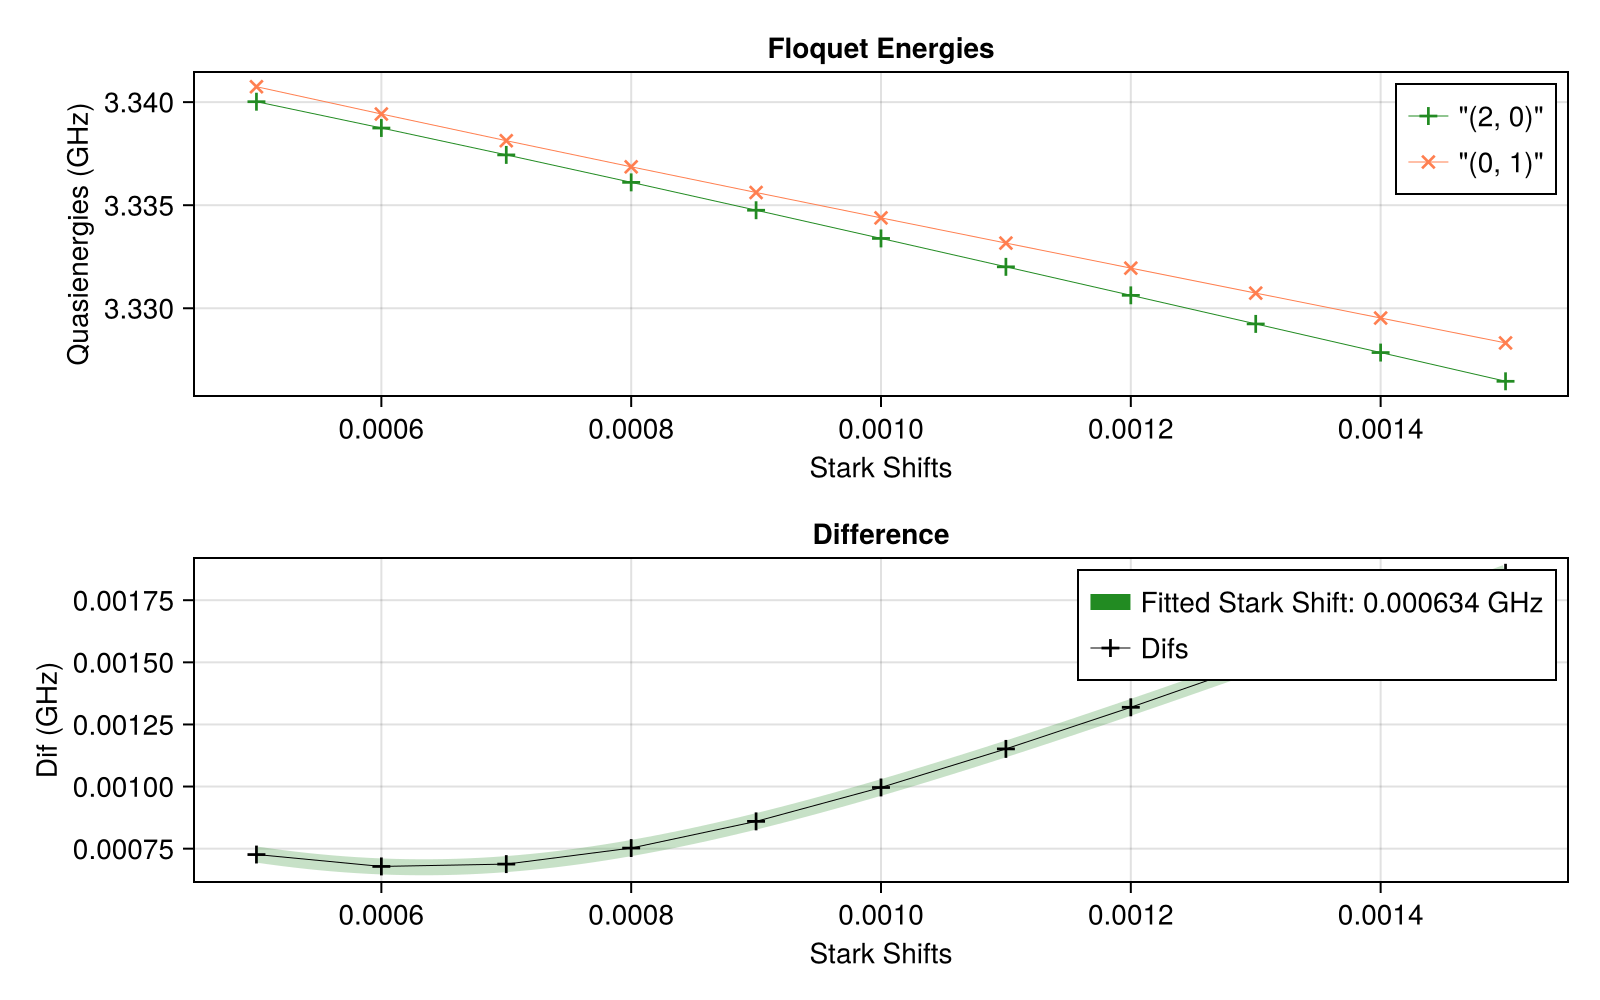

2-element Vector{Float64}:
    0.0006339817019192669
 1481.2981100730187

In [97]:
ε = eps_f0g1_4pi_f3g4
drive_op = Mode3.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

stark_shift_list = collect(LinRange(0.0005, 0.0015, 11))

stark_shift_res_f0g1_4pi_f3g4 = SC.Dynamics.FindStarkShift(Mode3, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [98]:
ψ1 = Mode3.dressed_states[(2,n1)]
ψ2 = Mode3.dressed_states[(0,n1+1)]

freq_d = Mode3.dressed_energies[(0,n1+1)]-Mode3.dressed_energies[(2, n1)]

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)

stark_shift = stark_shift_res_f0g1_4pi_f3g4[1]
initial_time = stark_shift_res_f0g1_4pi_f3g4[2]

ν = abs((stark_shift+freq_d))
t_range = [initial_time, initial_time+2*ramp_time]

optimize_res_f0g1_4pi_f3g4 = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, eps_f0g1_4pi_f3g4, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1)

[2024-11-07 19:05:25] Info: On Level 1
[2024-11-07 19:05:25] Info: On Step 1: t = 1481.2981100730187
[2024-11-07 19:05:25] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 24s (ETA: 0h 00m 00s)
[2024-11-07 19:05:50] Info: Time Evolution Complete
[2024-11-07 19:05:50] Info: Done with Level_1_step_1
[2024-11-07 19:05:50] Info: Accurace: 0.9997130290756879
[2024-11-07 19:05:50] Info: ------------------------------------------------------------------------------
[2024-11-07 19:05:50] Info: On Step 2: t = 1487.1109600730188
[2024-11-07 19:05:50] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 34s (ETA: 0h 00m 00s)
[2024-11-07 19:06:25] Info: Time Evolution Complete
[2024-11-07 19:06:25] Info: Done with Level_1_step_2
[2024-11-07 19:06:25] Info: Accurace: 0.9998286955245538
[2024-11-07 19:06:25] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1492.92
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1492.92, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0933253
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000633982
  "accuracy"      => 0.999869
  "freq_d"        => -2.86996

In [99]:
#Mode3.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1492.92
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1492.92, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0933253
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000633982
  "accuracy"      => 0.999869
  "freq_d"        => -2.86996

In [100]:
ψ = Mode3.dressed_states[(2,0)]+Mode3.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f0g1_4pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["sb_f0g1_4pi_f3g4"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-07T19:08:20.795
It is being saved at: Data/
[2024-11-07 19:08:20] Info: Running operator sb_f0g1_4pi_f3g4
[2024-11-07 19:08:20] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 25s (ETA: 0h 00m 00s)
[2024-11-07 19:08:46] Info: Time Evolution Complete
[2024-11-07 19:08:46] Info: Saving Steps
[2024-11-07 19:08:50] Info: Done with Step_1
[2024-11-07 19:08:50] Info: Done With Running Sequence
[2024-11-07 19:08:50] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.19999, 0.39998, 0.599969, 0.799959, 0.999949, 1.19994,…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [110]:
EVs_Dict = SC.Utils.Get_EVs(res_f0g1_4pi_f3g4["states"], proj_dict);

[2024-11-07 19:10:03] Info: Making Plot


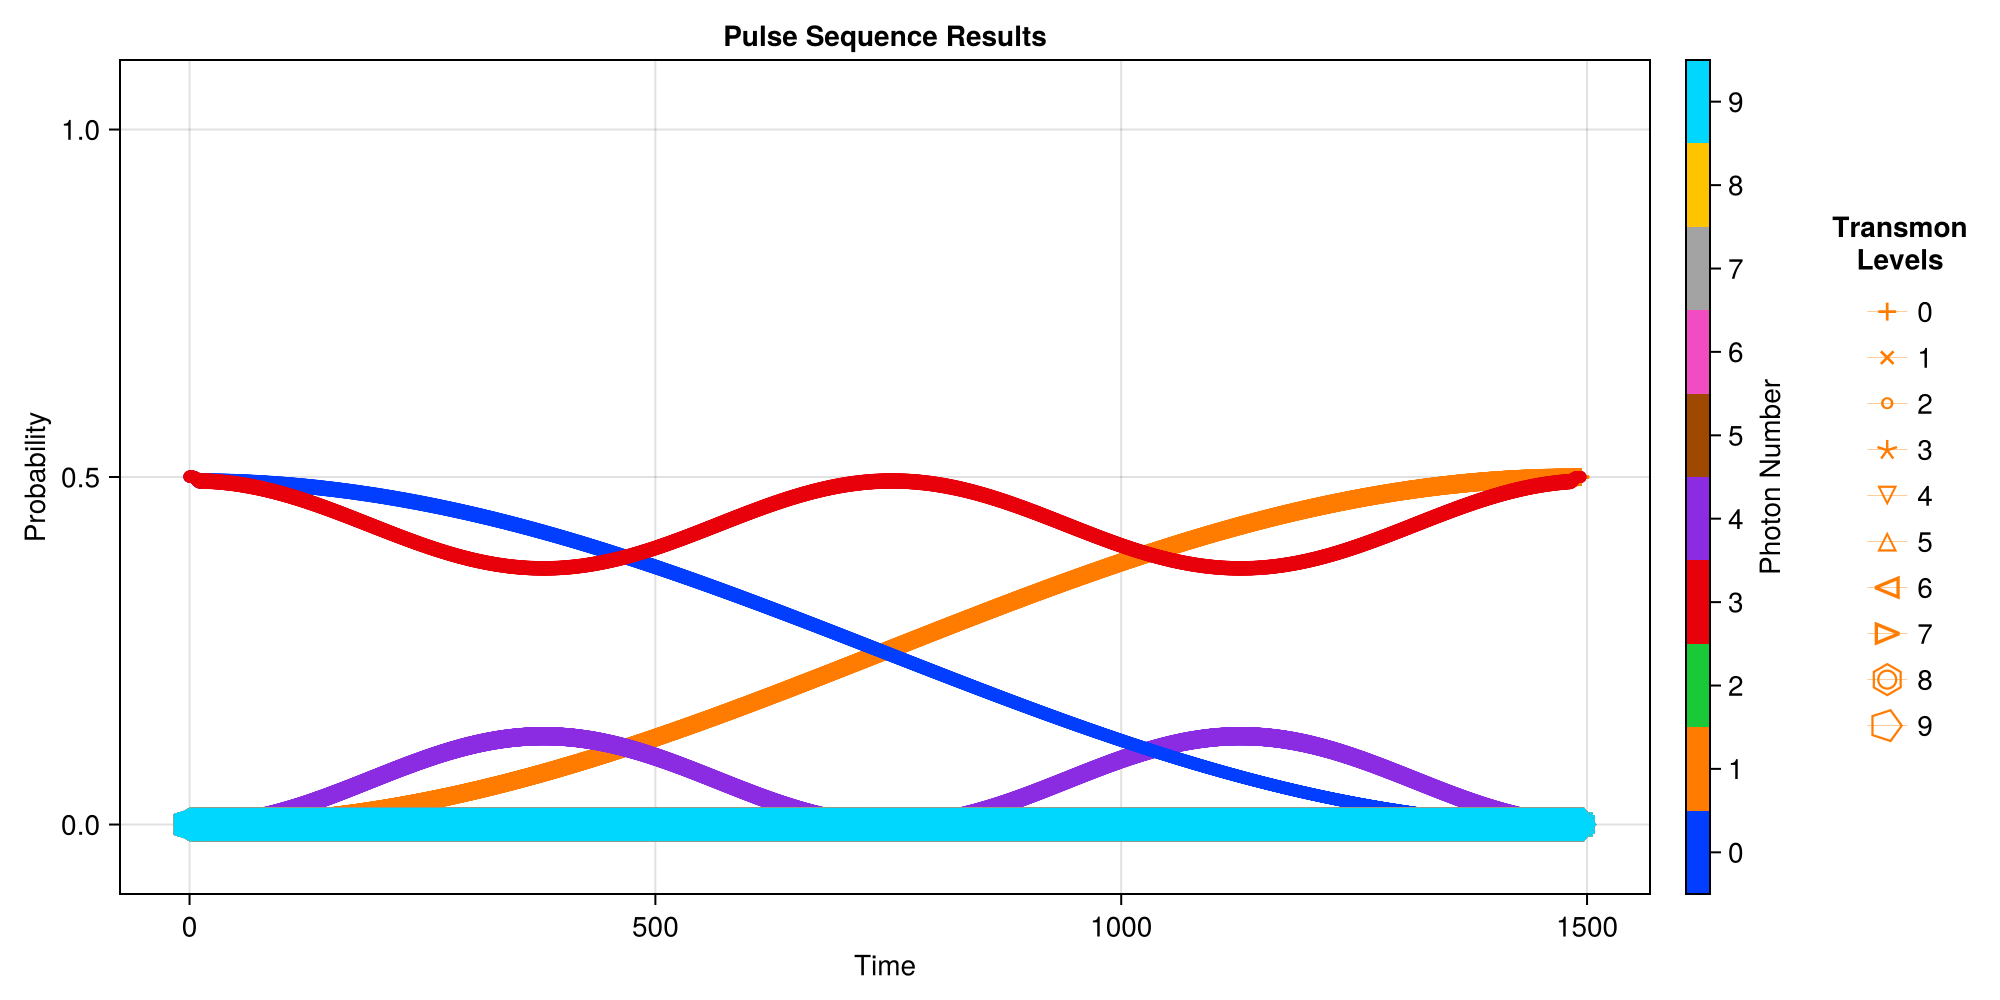

CairoMakie.Screen{IMAGE}


In [111]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, res_f0g1_4pi_f3g4["times"], EVs_Dict)

In [112]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,1)][end])

0.49947105007414233 - 5.0154487546073945e-18im
0.4999337535337773 + 4.220741597034458e-17im


#### Half Sideband $|f1\rangle \to |f1\rangle+|g2\rangle$

In [78]:
Mode3.Stuff["op_drive_params"]["sb_f1g2"]["pulse_time"]

148.61306365575186

In [126]:
starting_args = deepcopy(Mode3.Stuff["op_drive_params"]["sb_f1g2"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]

ψ1 = Mode3.dressed_states[(2,1)]
ψ2 = Mode3.dressed_states[(2,1)] + Mode3.dressed_states[(0,2)]
ψ2 = ψ2/sqrt(2)

proj_op = Mode3.dressed_states[(2,1)]*Mode3.dressed_states[(0,2)]'
op = 2*proj_op# proj_dict[(2,1)]+proj_dict[(0,2)]


t_range = [69.8, 70.2]
t_range = [70.8, 71.2]
t_range = [77, 88]


optimize_res_half_f1g2 = SC.Dynamics.OptimizePulse(Mode3, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 5, samples_per_level = 5, check_op = op)

[2024-11-07 20:06:21] Info: On Level 1
[2024-11-07 20:06:21] Info: On Step 1: t = 77.0
[2024-11-07 20:06:21] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:06:23] Info: Time Evolution Complete
[2024-11-07 20:06:23] Info: Done with Level_1_step_1
[2024-11-07 20:06:23] Info: Accurace: 0.9969049849470554
[2024-11-07 20:06:23] Info: ------------------------------------------------------------------------------
[2024-11-07 20:06:23] Info: On Step 2: t = 79.75
[2024-11-07 20:06:23] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:06:25] Info: Time Evolution Complete
[2024-11-07 20:06:25] Info: Done with Level_1_step_2
[2024-11-07 20:06:25] Info: Accurace: 0.9998806362836249
[2024-11-07 20:06:25] Info: ------------------------------------------------------------------------------
[2024-11-07 20:06:25] Info: On

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 80.4375
  "Envelope Args" => Dict{String, Any}("pulse_time"=>80.4375, "k"=>2, "ramp_tim…
  "epsilon"       => 0.735
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0376647
  "accuracy"      => 1.0
  "freq_d"        => -2.86958

In [123]:
ψ2'*(op*ψ2)

1.0000000000000004 + 0.0im

In [127]:
#Mode3.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
if GLOBAL_SAVE_CALIBRATE | false
    Mode3.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 80.4375
  "Envelope Args" => Dict{String, Any}("pulse_time"=>80.4375, "k"=>2, "ramp_tim…
  "epsilon"       => 0.735
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0376647
  "accuracy"      => 1.0
  "freq_d"        => -2.86958

In [128]:
ψ = Mode3.dressed_states[(2,1)]
res_half_f1g2 = SC.Dynamics.RunPulseSequence(Mode3, ψ, ["sb_half_f1g2"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-07T20:07:05.398
It is being saved at: Data/
[2024-11-07 20:07:05] Info: Running operator sb_half_f1g2
[2024-11-07 20:07:05] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-07 20:07:06] Info: Time Evolution Complete
[2024-11-07 20:07:06] Info: Saving Steps
[2024-11-07 20:07:07] Info: Done with Step_1
[2024-11-07 20:07:07] Info: Done With Running Sequence
[2024-11-07 20:07:07] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199597, 0.399194, 0.59879, 0.798387, 0.997984, 1.19758…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [129]:
EVs_Dict = SC.Utils.Get_EVs(res_half_f1g2["states"], proj_dict);

[2024-11-07 20:07:07] Info: Making Plot


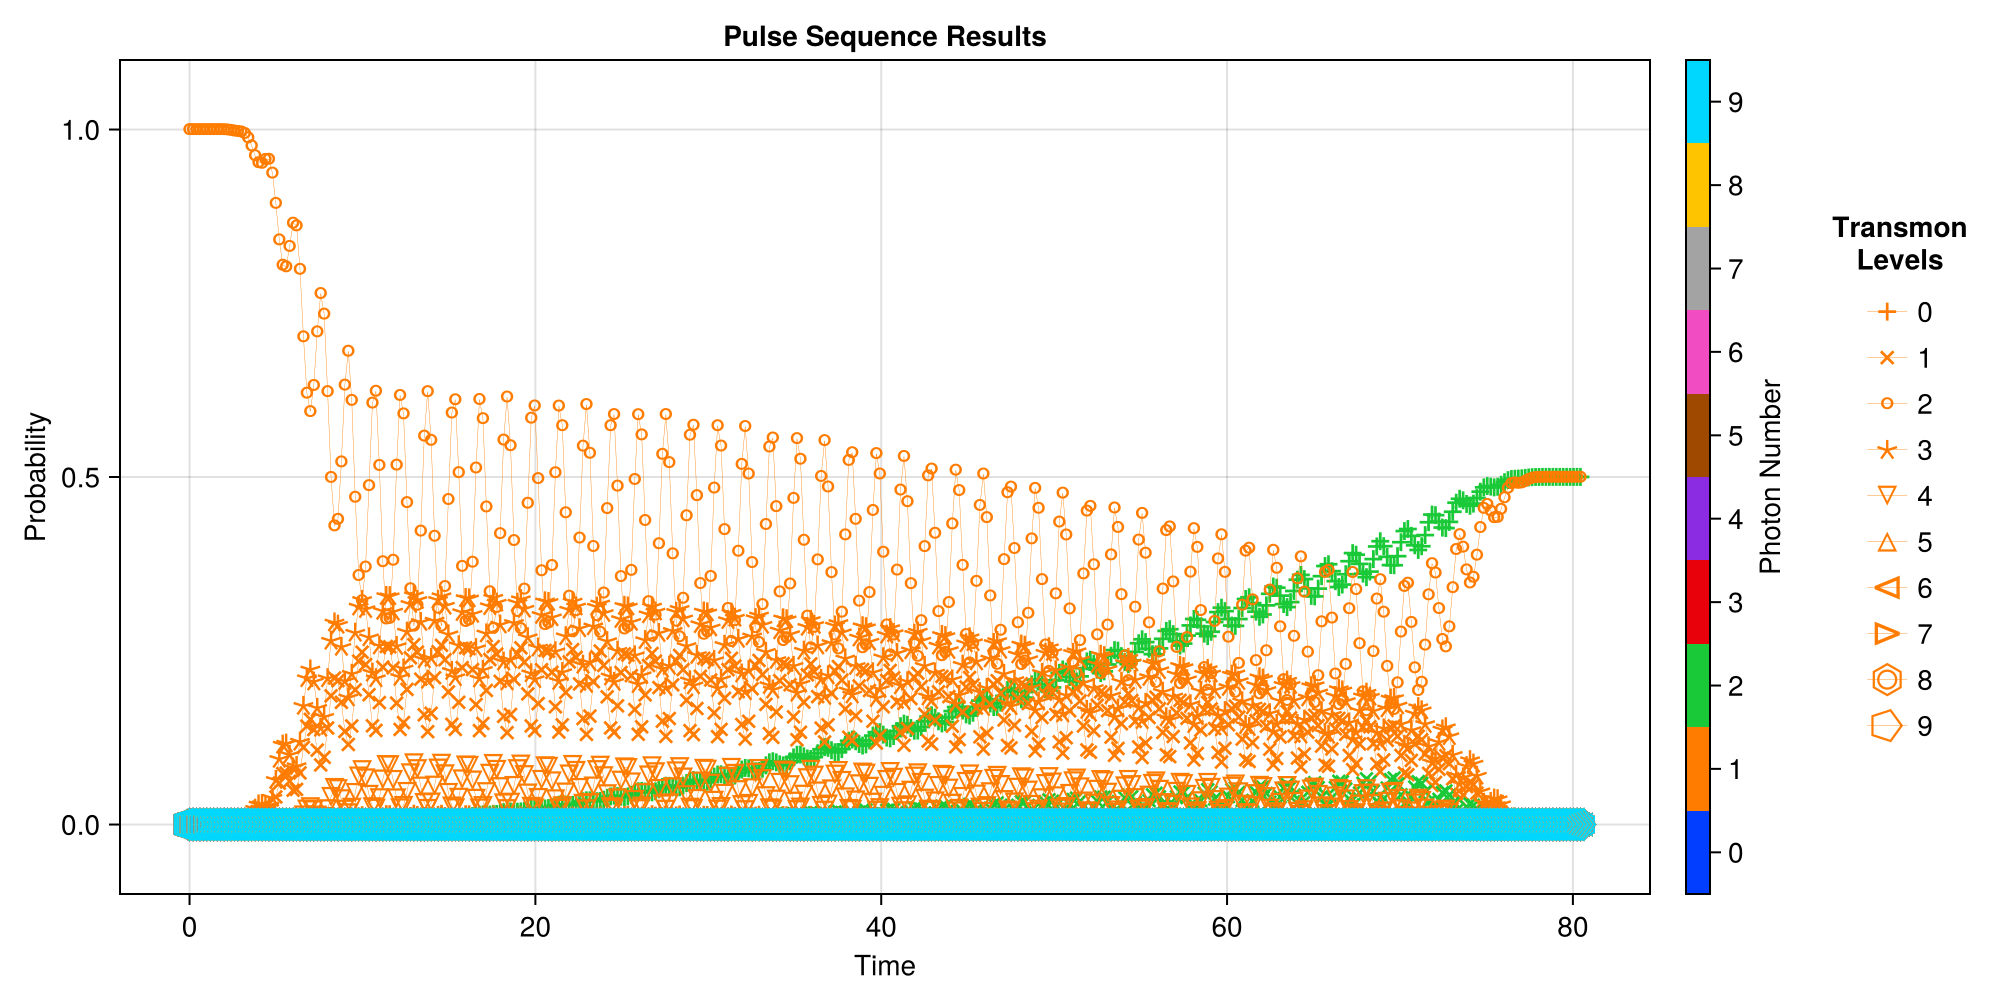

CairoMakie.Screen{IMAGE}


In [130]:
SC.Dynamics.PlotSingleModeEvolution(Mode3, res_half_f1g2["times"], EVs_Dict)

In [131]:
println(EVs_Dict[(2,1)][end])
println(EVs_Dict[(0,2)][end])

0.4998095649782295 + 4.5222673417877193e-17im
0.5001901750375224 + 6.8081726113866006e-18im
